# This notebook performs statistical analysis and visualizes the cumulative distribution of the conditional essentiality counts

## Import modules: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import bokeh.io
import bokeh.plotting
import holoviews as hv 
import hvplot
import hvplot.pandas

import re

## Function definitions: 

In [2]:
def essential_subset(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df_temp[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df_temp.sort_values(by=subset_name, ascending=False, inplace=True)
    df_temp.reset_index(inplace=True, drop=True)
    df_temp = df_temp[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df_temp

## Files and paths: 

In [3]:
dir_data = '../../data/standardized_data'
dir_figs = '../../figures/Tn_mat_stats'

Load binary dataset: 

In [4]:
# version = 'old'
#version = 'clare_basis'
# version = 'clare_all'

#if version == 'old':
#    bin_file = os.path.join(dir_data, 'result_bin_matrix_2020_08_27.csv') ## data set without Claire's screens
#elif version == 'clare_all':
#    bin_file = os.path.join(dir_data, 'result_bin_matrix_2021_08_27.csv') ## data set with all of Claire's pairwise combinations
#elif version == 'clare_basis':
#     bin_file = os.path.join(dir_data, 'result_bin_matrix_2021_10_22_BASIS.csv') ## data set only Claire's mutant vs. wildtype screens
#     lfc_file = os.path.join(dir_data, 'result_logfc_matrix_2021_10_22_BASIS.csv')
    
#    bin_file = os.path.join(dir_data, 'result_bin_matrix_2021_11_15_BASIS_invitro.csv') ## data set only Claire's mutant vs. wildtype screens
#    lfc_file = os.path.join(dir_data, 'result_logfc_matrix_2021_11_15_BASIS_invitro.csv')
#    
#df_bin = pd.read_csv(bin_file)
#df_lfc = pd.read_csv(lfc_file)
#df_bin.head(2)

In [5]:
bin_file = os.path.join(dir_data, 'result_bin_matrix_2023_02_20_CC_BxD_processed.csv')
lfc_file = os.path.join(dir_data, 'result_logfc_matrix_2023_02_20_CC_BxD_processed.csv')    
df_bin = pd.read_csv(bin_file)
df_lfc = pd.read_csv(lfc_file)
df_bin.head(2)

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD69_vs_in_vitro_H37Rv,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv
0,Rv0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rv0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Subset of columns from Clare's dataset: 

In [6]:
cols_temp_CS = df_lfc.columns[65:].tolist()
len(cols_temp_CS)

82

In [7]:
fn_col_desc = '../../data/meta_data/old_column_descriptors/column_descriptors_standardized_092321.xlsx'
df_col_desc = pd.read_excel(fn_col_desc)
df_col_desc.head(1)

,column_ID,wig_files,control,experimental,column_ID_2,column_ID_SI,num_replicates_control,num_replicates_experimental,meaning,year,...,carbon_source,stress_description,GI_RvID,GI_name,MicArr_or_TnSeq,stat_analysis,mouse_strain,cell_type,Mtb_strain,plot_SI_graph
0,2003A_Sassetti,NaN,NaN,NaN,NaN,2003A_Sassetti,NaN,NaN,NaN,2003.0,...,glycerol,-,NaN,NaN,microarray,NaN,NaN,NaN,H37Rv,No


In [8]:
df_col_desc.in_vitro_cell_vivo.value_counts()

in_vitro_cell_vivo
in_vivo             86
in_vitro            47
in_cell              2
in_vivo_in_vitro     2
Name: count, dtype: int64

In [9]:
df_bin['sum_CES'] = df_bin.sum(numeric_only=True, axis = 1)

### Annotations: 

In [10]:
#### COG
file_cog = '../../data/annotations/H37Rv_COG_mapping.xlsx'
df_cog_map = pd.read_excel(file_cog)

file_cog_def = '../../data/annotations/cog_names.csv'
df_cog_def = pd.read_csv(file_cog_def)
df_cog_def.rename(columns = {'COG_Desc':'cog_annot'}, inplace = True)

#merge mapping with definitions: 
df_cog_map_def = df_cog_map.merge(df_cog_def, how='left', on = 'COG')
# Merge with binary matrix:
df_bin_cog = df_bin.merge(df_cog_map, how = 'left', on = 'Rv_ID')

#### Tuberculist
file_tub = '../../data/annotations/H37Rv_tuberculist_functional_categories.xlsx'
df_tub = pd.read_excel(file_tub)
df_tub.rename(columns = {'category':'func_tuberculist'}, inplace = True)
# merge
df_bin_annot = df_bin_cog.merge(df_tub, how = 'left', on = 'Rv_ID')
df_bin_annot = df_bin_annot[['Rv_ID', 'gene_name', 'func_tuberculist', 'COG'] + list(df_bin.columns[1:])]
df_bin_annot.iloc[:,:4].head(3)

,Rv_ID,gene_name,func_tuberculist,COG
0,Rv0001,dnaA,information pathways,L
1,Rv0002,dnaN,information pathways,L
2,Rv0003,recF,information pathways,L


# Rank columns by the number of essential genes. 

### Why are there so many essential calls when comparing "in_vitro" and "mbio_H37Rv":

In [11]:
df_bin.sum(numeric_only=True).sort_values(ascending = False).head(20)

sum_CES                                              12326.0
mbio_H37Rv_vs_in_vitro                                 435.0
dejesus_Rv1432_day0_vs_dejesus_H37Rv_day0              406.0
zhang_wt_mouse_d45_vs_zhang_input_library              328.0
dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0              312.0
marP_KO_vs_marP_WT                                     263.0
dejesus_Rv1565c_day32_vs_dejesus_H37Rv_day32           253.0
minato_minimal_plate_vs_minato_rich_plate              222.0
ritterhaus_hypoxia_H6_vs_ritterhaus_hypoxia_input      214.0
xu_inh_025_vs_xu_inh_0                                 180.0
dejesus_Rv1565c_day0_vs_dejesus_H37Rv_day0             178.0
carey_621_vs_carey_rv                                  177.0
dejesus_Rv2680_day32_vs_dejesus_Rv2680_day0            144.0
CC019.TauUnc_vs_in_vitro                               139.0
CC018.Unc_vs_in_vitro                                  135.0
carey_663_vs_carey_rv                                  135.0
C57BL.6J_vs_in_vitro    

Visualize: 

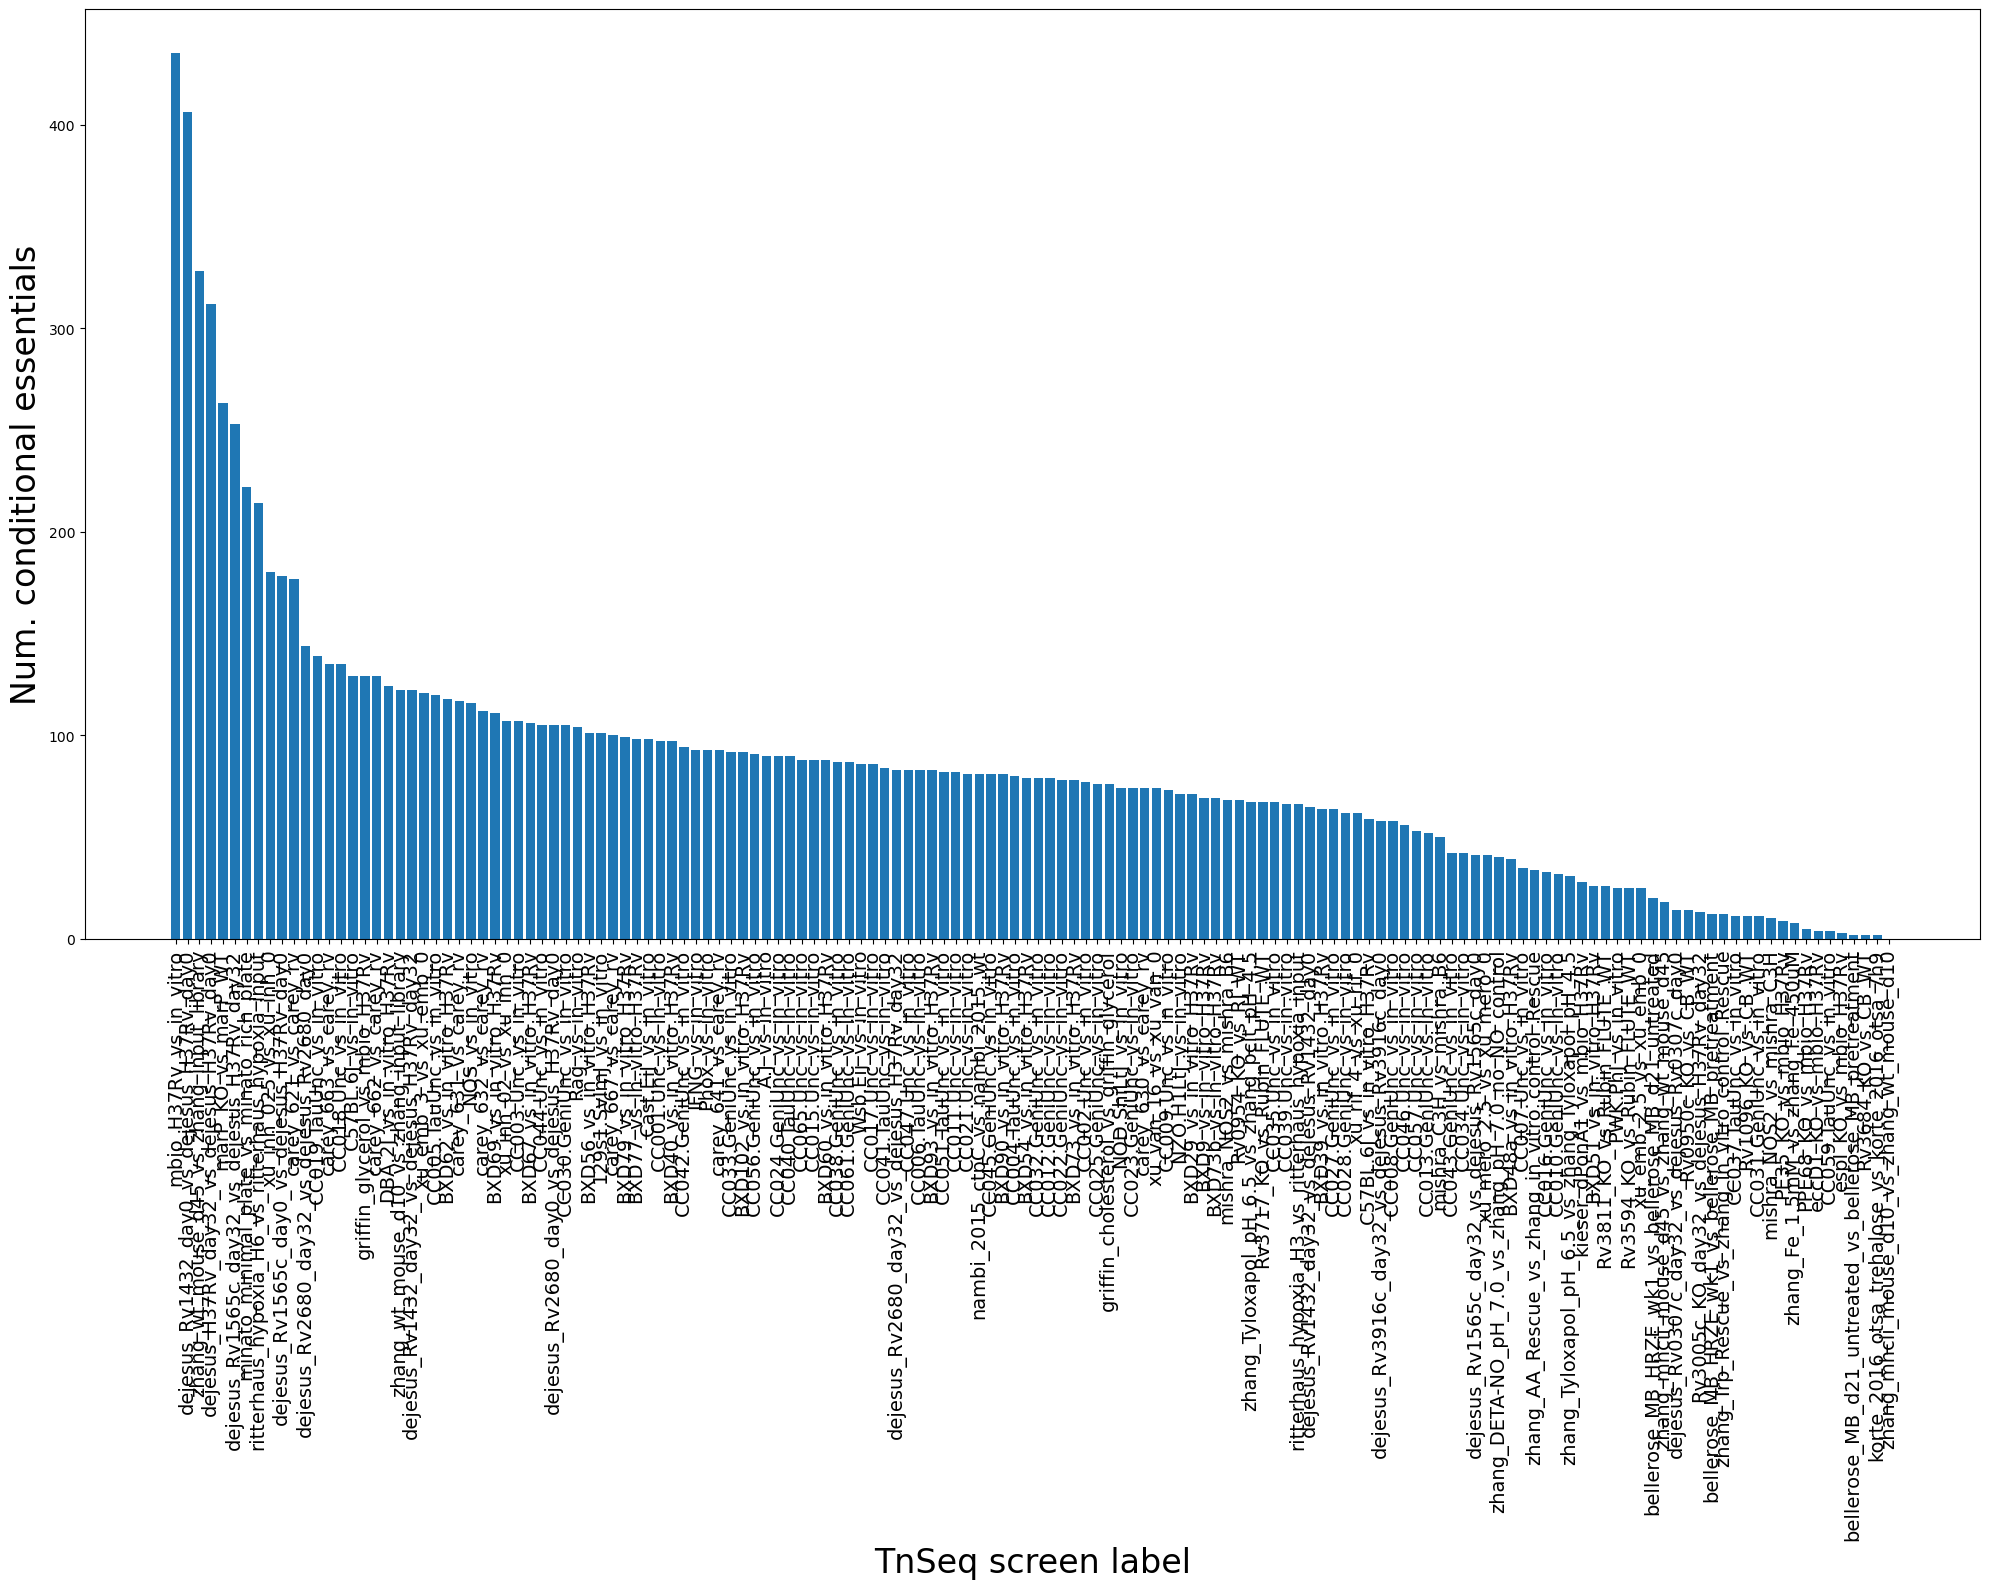

In [12]:
df_Tn_screen_stats = df_bin[df_bin.columns[:-1]].sum(numeric_only=True).sort_values(ascending = False)
vals = df_Tn_screen_stats.values
labels = df_Tn_screen_stats.keys()
xvals = np.arange(len(vals))
plt.figure(figsize = (20,16))
plt.bar(xvals, vals)
plt.ylabel('Num. conditional essentials', fontsize = 24)
xt = plt.xticks(xvals, np.array(labels), rotation = 90, fontsize = 14)
plt.xlabel('TnSeq screen label', fontsize = 24)
plt.tight_layout()
file_out = os.path.join(dir_figs, 'Tn_screen_stats.png')
# plt.savefig(file_out, dpi = 300)

# Rank genes by the number of times they're essential across conditions: 

In [13]:
df_rv_sum = df_bin[['Rv_ID', 'sum_CES']].copy()
df_rv_sum['Rv_num'] = np.arange(df_rv_sum.shape[0])
df_rv_sum.head(5)

,Rv_ID,sum_CES,Rv_num
0,Rv0001,0.0,0
1,Rv0002,0.0,1
2,Rv0003,3.0,2
3,Rv0004,0.0,3
4,Rv0005,0.0,4


In [14]:
df_rv_sum[df_rv_sum.sum_CES == 0]

,Rv_ID,sum_CES,Rv_num
0,Rv0001,0.0,0
1,Rv0002,0.0,1
3,Rv0004,0.0,3
4,Rv0005,0.0,4
7,Rv0008c,0.0,7
...,...,...,...
4046,Rv3917c,0.0,4046
4047,Rv3918c,0.0,4047
4050,Rv3921c,0.0,4050
4052,Rv3923c,0.0,4052


In [15]:
df_xticks = df_rv_sum[df_rv_sum.Rv_ID.isin(['Rv0001', 'Rv0500', 'Rv1000c', 'Rv1500', 'Rv2000', 'Rv2500c', 'Rv3000', 'Rv3500c', 'Rv3900c'])]

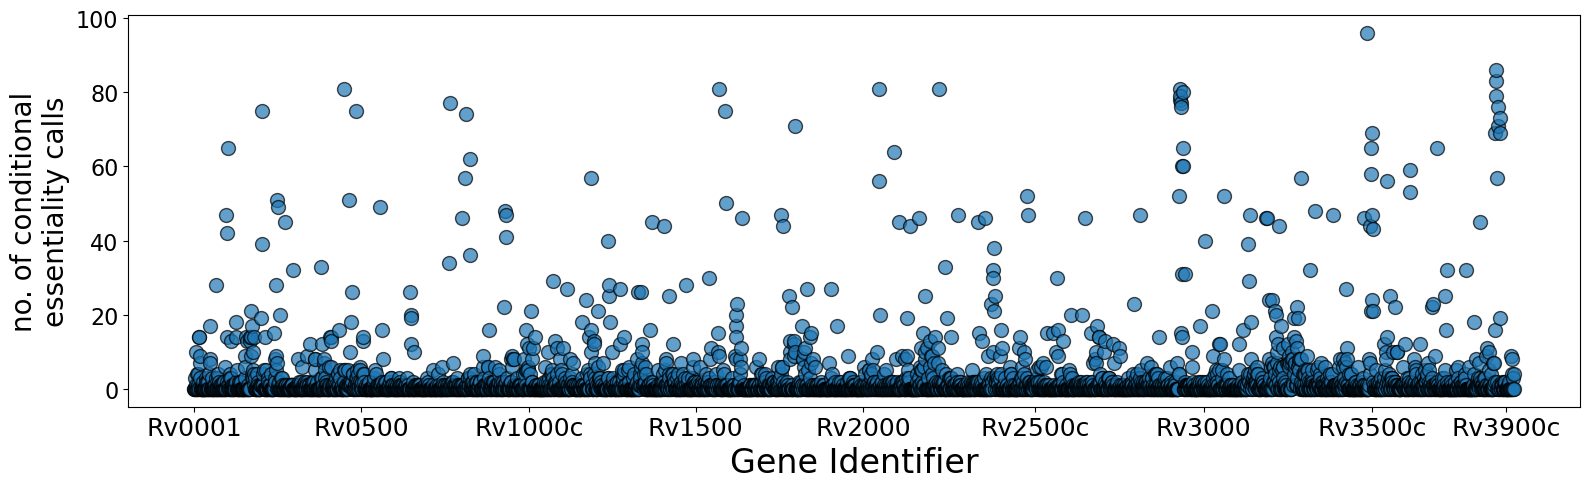

In [16]:
plt.figure(figsize = (16,5))
plt.scatter(df_rv_sum.Rv_num, df_rv_sum.sum_CES, s = 100, edgecolors='k', alpha = 0.7)
# plt.ylim(0, 30)
xt = plt.xticks(list(df_xticks.Rv_num), list(df_xticks.Rv_ID), fontsize = 18)
plt.xlabel('Gene Identifier', fontsize = 24)
yt = plt.yticks(fontsize = 16)
plt.ylabel('no. of conditional\nessentiality calls', fontsize = 20)
plt.tight_layout()


#### Sliding window average:

In [17]:
window_size = 4
list_mean_counts = []
for i in range(0, df_rv_sum.shape[0] - window_size):
    window = range(i, i+window_size)
    df_temp = df_rv_sum.iloc[window]
    mean_counts = df_temp.sum_CES.mean()
    list_mean_counts.append(mean_counts)

In [18]:
df_rv_sum_window = df_rv_sum[2:-2].copy()
df_rv_sum_window['mean_sum_CES'] = list_mean_counts

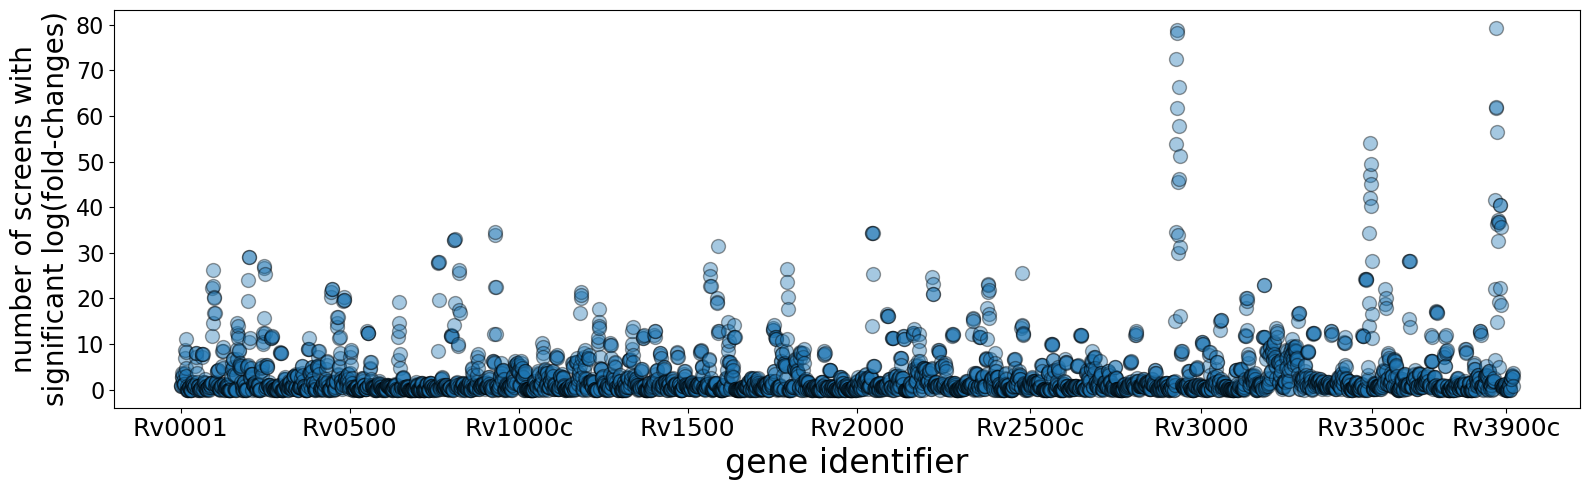

In [19]:
plt.figure(figsize = (16,5))

plt.scatter(range(df_rv_sum.shape[0] - window_size), list_mean_counts, s = 100, edgecolors='k', alpha = 0.4)
# plt.plot(range(df_rv_sum.shape[0] - window_size), list_mean_counts, 'k')
# plt.ylim(0, 26)
xt = plt.xticks(list(df_xticks.Rv_num), list(df_xticks.Rv_ID), fontsize = 18)
plt.xlabel('gene identifier', fontsize = 24)
yt = plt.yticks(fontsize = 16)
plt.ylabel('number of screens with\nsignificant log(fold-changes)', fontsize = 20)
plt.tight_layout()

file_out = os.path.join(dir_figs, 'Tn_manhattan_window_061824.png')
plt.savefig(file_out, dpi = 300)

In [20]:
rvlist = ['Rv'+str(n) for n in range(2931,2936)]
df_bin[df_bin['Rv_ID'].isin(rvlist)]['sum_CES']

3027    78.0
3028    81.0
3029    79.0
3030    77.0
3031    76.0
Name: sum_CES, dtype: float64

#### Interactive versions: 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
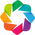

:Scatter   [Rv_num]   (sum_CES,Rv_ID)

In [21]:
gene_plot=df_rv_sum.hvplot.scatter(
    x = 'Rv_num', 
    y = 'sum_CES', xlabel="Gene Identifier", ylabel="sum CES",
    hover_cols = ['Rv_ID', 'sum_CES'],
    cmap = 'Accent', 
    alpha = 0.4,
    padding = 0.1, 
    size = 55,
    width = 1300,
    height = 500
)
hv.extension('bokeh')
gene_plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
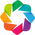

:Scatter   [Rv_num]   (mean_sum_CES,Rv_ID,sum_CES)

In [22]:
gene_plot=df_rv_sum_window.hvplot.scatter(
    x = 'Rv_num', 
    y = 'mean_sum_CES', xlabel="Gene Identifier", ylabel="Mean sum CES",
    hover_cols = ['Rv_ID', 'sum_CES'],
    cmap = 'Accent', 
    alpha = 0.4,
    padding = 0.1, 
    size = 55,
    width = 1300,
    height = 500
)
hv.extension('bokeh')
gene_plot

## Digging deeper into loci: 

Load the new annotated UniProt dataframe: 

In [23]:
fn_up_func = '../../data/annotations/uniprotkb_mtb_2023_12_20.xlsx'
df_up_func = pd.read_excel(fn_up_func)
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene Names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func['annot_int'] = df_up_func.Annotation
df_up_func = df_up_func[['Rv_ID', 'annot_int', 'Gene Names']].copy()

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_22042/536219117.py:3: SyntaxWarning: invalid escape sequence '\d'
  re_str = 'Rv\d\d\d\dc?'
/Users/amandaspencer/miniconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# [WARNING] All of this needs to be worked on: 

In [24]:
th = 10
list_rvid_all = df_rv_sum_window[df_rv_sum_window.mean_sum_CES>= th].Rv_ID.tolist()
len(list_rvid_all)

322

In [25]:
df_up_func.columns

Index(['Rv_ID', 'annot_int', 'Gene Names'], dtype='object')

In [26]:
file_out = '../../data/coessential_loci_th10.xlsx'
df_up_func[df_up_func.Rv_ID.isin(list_rvid_all)].sort_values(by = 'Rv_ID').to_excel(file_out, index = False)

In [27]:
list_rv_id = df_rv_sum_window[df_rv_sum_window.mean_sum_CES>= th].head(20).Rv_ID.tolist()
df_up_func[df_up_func.Rv_ID.isin(list_rv_id)]

,Rv_ID,annot_int,Gene Names
187,Rv0018c,5.0,pstP mstp ppp Rv0018c
298,Rv0098,5.0,fcoT Rv0098 MTCY251.17
425,Rv0099,5.0,fadD10 Rv0099
471,Rv0203,4.0,Rv0203 RVBD_0203 P425_00212
788,Rv0101,4.0,nrp Rv0101
981,Rv0097,3.0,Rv0097 MTCY251.16
1144,Rv0202c,3.0,mmpL11 Rv0202c MTV033.10c
1191,Rv0100,3.0,Rv0100 MTCY251.19
1322,Rv0103c,3.0,ctpB Rv0103c MTCY251.22c
1407,Rv0174,2.0,mce1F Rv0174


Now you need to make the different lists: 

In [28]:
rvid = 'Rv0644c'
df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
cols = df_bin_annot.columns[4:-1]
cols_temp = [col for col in cols if df_temp[col].values[0] == 1]
cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]

In [29]:
file_in = '../../data/other_repos_PENDING_MOVE/GLS_AF2_related/coessential_loci_th20.xlsx'
df_loci = pd.read_excel(file_in)
df_loci.columns

Index(['locus', 'locus_name', 'Rv_ID', 'annot_int', 'Gene names',
       'Function [CC]'],
      dtype='object')

In [30]:
locus_name = 'mce-1'
list_rv_id = df_loci[df_loci.locus_name == locus_name].Rv_ID.values

In [31]:
locus_name = 'mbt_1_and_2'
list_rv_id = ['Rv1347c','Rv1344','Rv1345','Rv1346','Rv2384','Rv2383c','Rv2382c','Rv2381c','Rv2380c','Rv2379c','Rv2378c','Rv2386c']

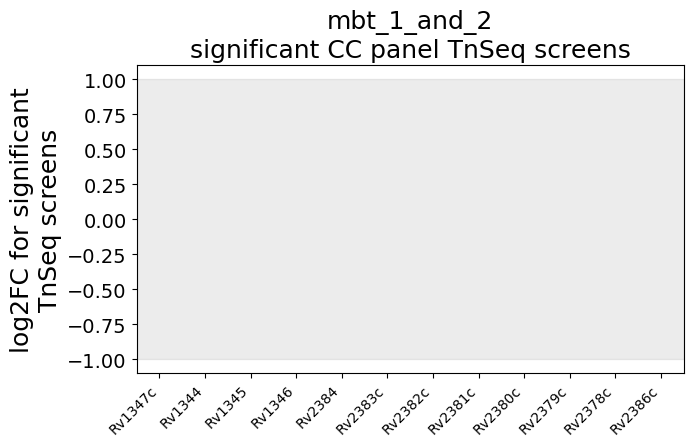

In [32]:
dict_cols = {}
for rvid in list_rv_id:
    df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
    cols = df_bin_annot.columns[4:-1]
    cols_sig = [col for col in cols if df_temp[col].values[0] == 1]
    dict_cols[rvid] = cols_sig

# Get lfc values for those screens, partitioned into mouse CC panel and other screens:     
ll_lfc_all = []
ll_lfc_CS = []
ll_lfc_nonCS = []
for rvid in list_rv_id:
    cols_temp = dict_cols[rvid]
#     cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
    cols_temp_CS = [col for col in cols_temp if '_'.join(col.split('_')[:2]) == 'in_vitro']
#     cols_temp_nonCS = [col for col in cols_temp if not 'C57BL.6J' in col]
    cols_temp_nonCS = [col for col in cols_temp if col not in cols_temp_CS]

    list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
    list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]
    list_lfc_nonCS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_nonCS].values[0]

    ll_lfc_all.append(list_lfc)
    ll_lfc_CS.append(list_lfc_CS)
    ll_lfc_nonCS.append(list_lfc_nonCS)


# make boxplots comparing lfc values: 
fig = plt.figure(figsize=(24,4))
ax = fig.add_subplot(131)
bp = plt.boxplot(ll_lfc_CS, showfliers=False)
plt.axhspan(-1,1, color = 'gray', alpha = 0.15)
# add individual points: 
x_vals = np.arange(1, len(ll_lfc_CS)+1)
for i in range(len(ll_lfc_CS)):
    ydata = ll_lfc_CS[i]
    xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-.1, high=+.1, size=len(ydata))
    plt.plot(xdata, ydata, 'k.')

# xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
yt = plt.yticks(fontsize = 14)
yl=plt.ylabel('log2FC for significant\nTnSeq screens', fontsize = 18)
ttl = plt.title(locus_name+'\nsignificant CC panel TnSeq screens', fontsize = 18)


In [33]:
def make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name):
# Make dictionary of screens with significant hits for each gene in identified loci: 
    rand_x = 0.05

    dict_cols = {}
    for rvid in list_rv_id:
        df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
        cols = df_bin_annot.columns[4:-1]
        cols_sig = [col for col in cols if df_temp[col].values[0] == 1]
        dict_cols[rvid] = cols_sig

    # Get lfc values for those screens, partitioned into mouse CC panel and other screens:     
    ll_lfc_all = []
    ll_lfc_CS = []
    ll_lfc_nonCS = []
    for rvid in list_rv_id:
        cols_temp = dict_cols[rvid]
#         cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
#         cols_temp_nonCS = [col for col in cols_temp if not 'C57BL.6J' in col]
        cols_temp_CS = [col for col in cols_temp if '_'.join(col.split('_')[:2]) == 'in_vitro']
        cols_temp_nonCS = [col for col in cols_temp if col not in cols_temp_CS]

        list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
        list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]
        list_lfc_nonCS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_nonCS].values[0]

        ll_lfc_all.append(list_lfc)
        ll_lfc_CS.append(list_lfc_CS)
        ll_lfc_nonCS.append(list_lfc_nonCS)

    # make boxplots comparing lfc values: 
    fig = plt.figure(figsize=(24,4))
    ax = fig.add_subplot(131)
    bp = plt.boxplot(ll_lfc_CS, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.15)
    # add individual points: 
    x_vals = np.arange(1, len(ll_lfc_CS)+1)
    for i in range(len(ll_lfc_CS)):
        ydata = ll_lfc_CS[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    yl=plt.ylabel('log2FC for significant\nTnSeq screens', fontsize = 18)
    plt.title(locus_name+'\nsignificant CC panel TnSeq screens', fontsize = 18)

    ax = fig.add_subplot(132)
    bp = plt.boxplot(ll_lfc_nonCS, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.3)
    x_vals = np.arange(1, len(ll_lfc_nonCS)+1)
    for i in range(len(ll_lfc_nonCS)):
        ydata = ll_lfc_nonCS[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    ttl = plt.title(locus_name+'\nother significant TnSeq screens', fontsize = 18)

    ax = fig.add_subplot(133)
    bp = plt.boxplot(ll_lfc_all, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.3)
    x_vals = np.arange(1, len(ll_lfc_all)+1)
    for i in range(len(ll_lfc_all)):
        ydata = ll_lfc_all[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    ttl = plt.title(locus_name+'\nall significant TnSeq screens', fontsize = 18)
    
    ## Saving figures: 
    plt.tight_layout()
    path_fig = '../../figures/Tn_mat_stats/'
    fn = 'boxplot_'+str(locus_name)+'.png'
    plt.savefig(os.path.join(path_fig, fn), dpi = 300)

___________________________________
_______________________________________

## FLIPPING THE SIGN OF THE CC-PANEL COMPARISONS!!!

In [34]:
cols_CS = [col for col in df_lfc.columns[1:] if '_'.join(col.split('_')[:2]) == 'in_vitro']
df_lfc[cols_CS] = -df_lfc[cols_CS]

___________________________________
_______________________________________

In [35]:
rvid = 'Rv1347c'
cols_temp = dict_cols[rvid]
cols_temp_CS = [col for col in cols_temp if '_'.join(col.split('_')[:2]) == 'in_vitro']
cols_temp_nonCS = [col for col in cols_temp if col not in cols_temp_CS]
df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS]

""
1384


After sign change: 

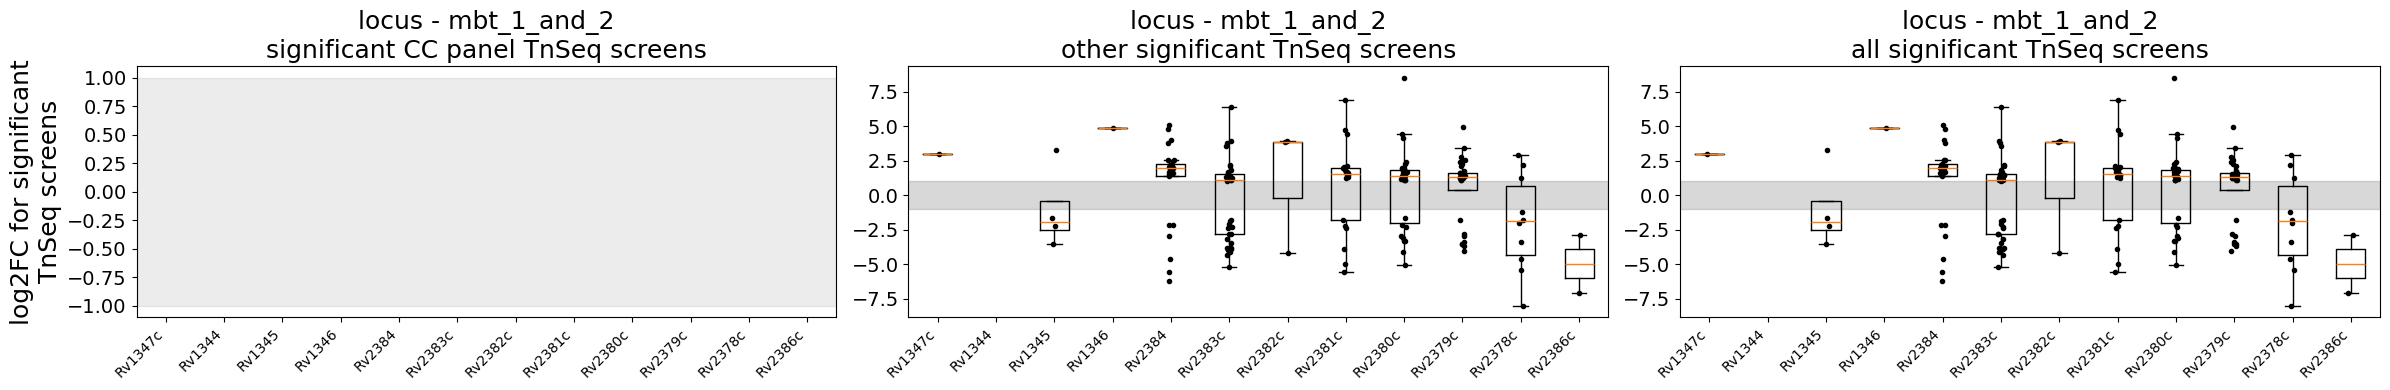

In [36]:
locus_name_str = 'locus - mbt_1_and_2'
make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name_str)

Before sign change: 

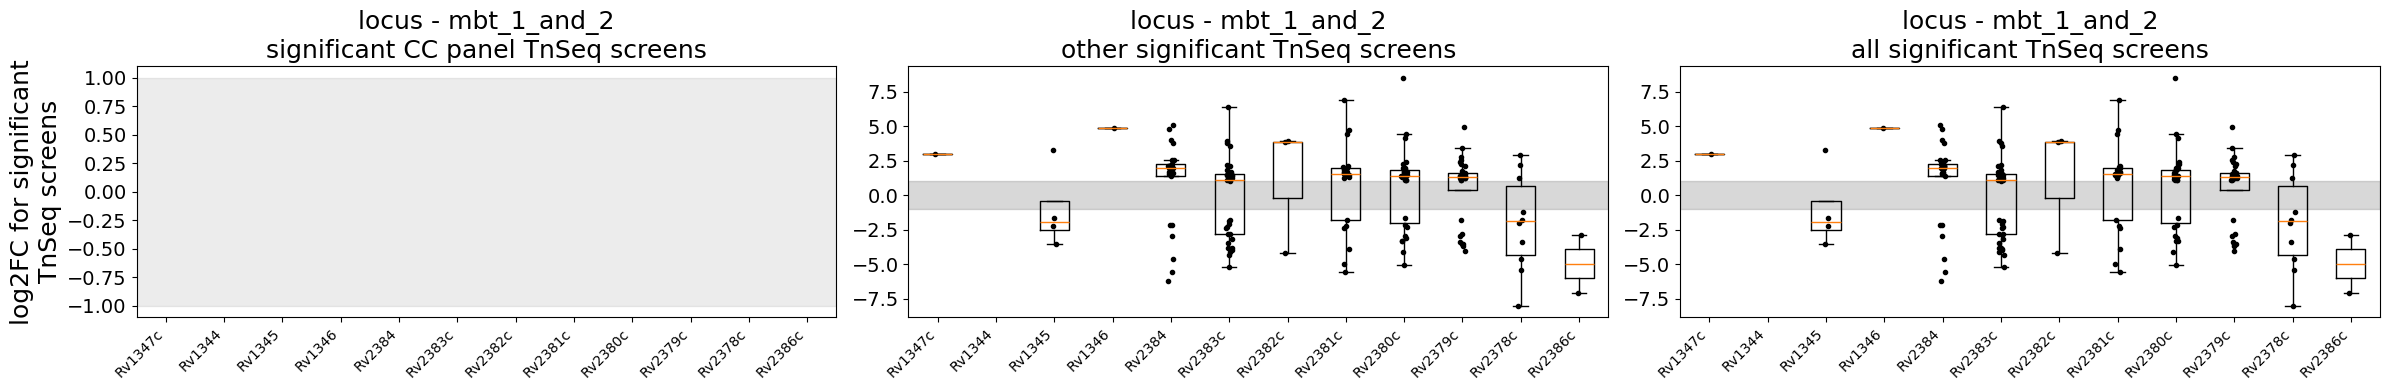

In [37]:
locus_name_str = 'locus - mbt_1_and_2'
make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name_str)

/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_22042/4170808997.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(24,4))


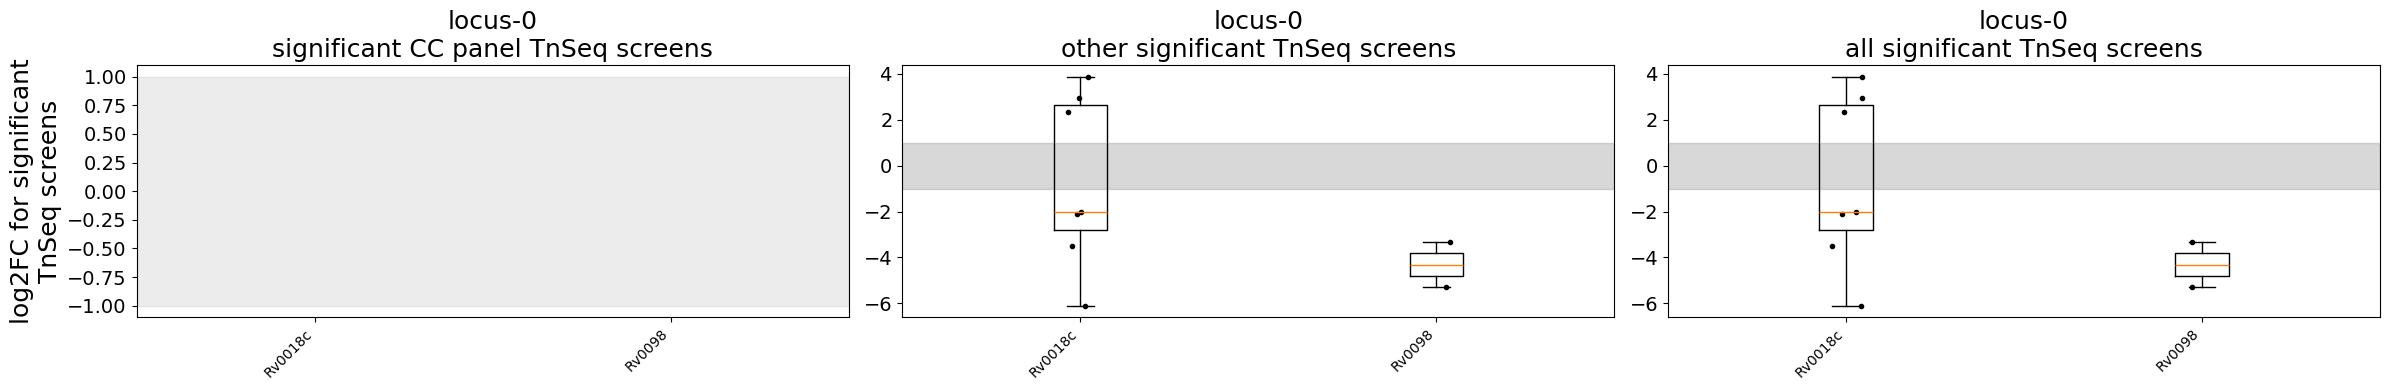

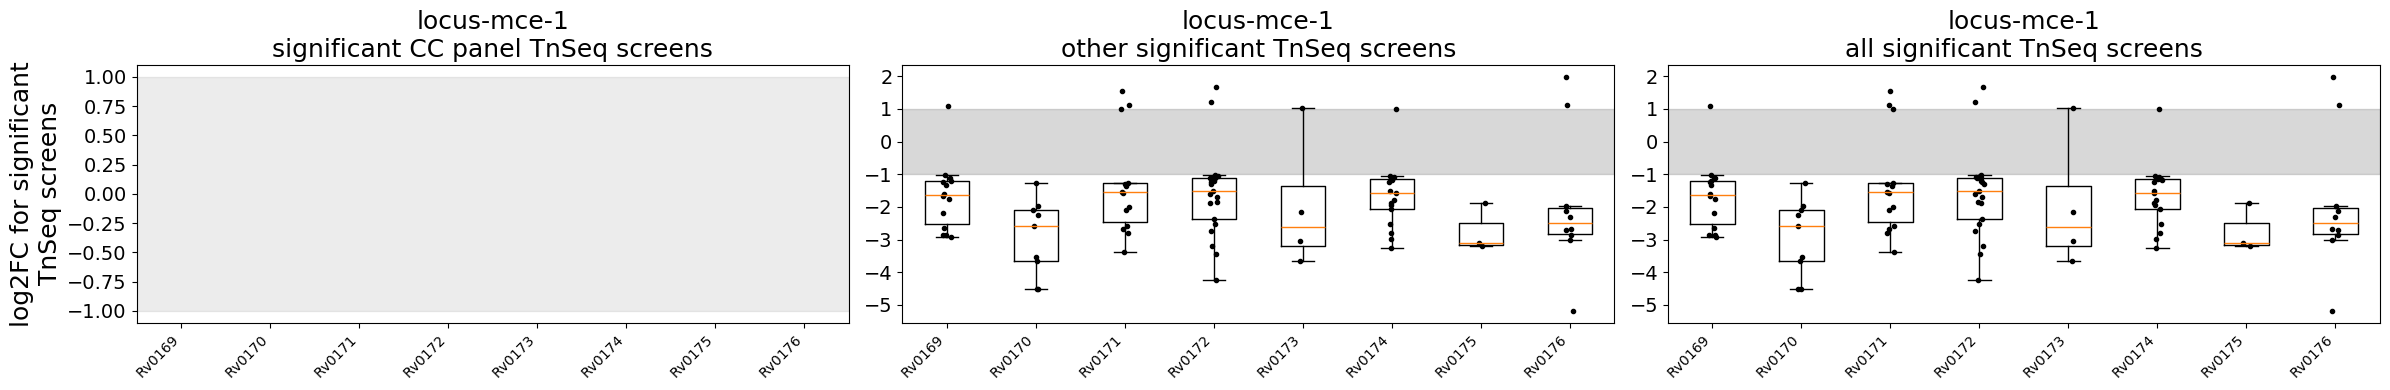

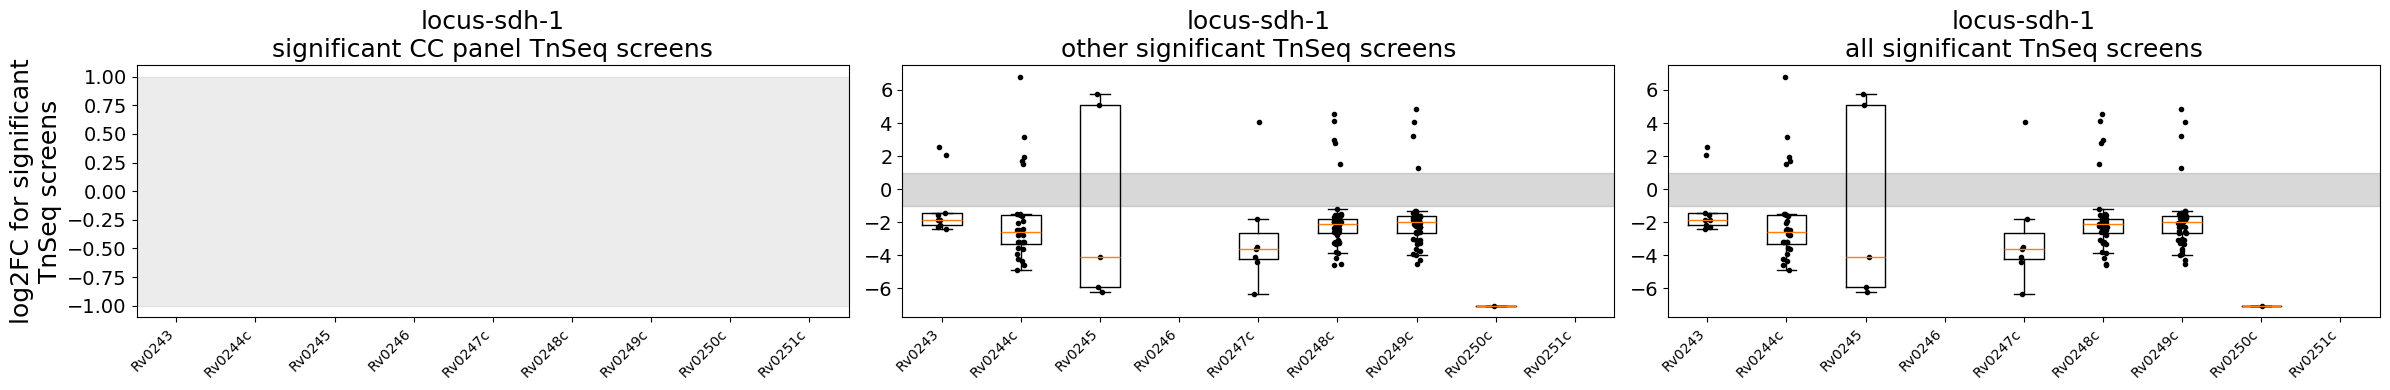

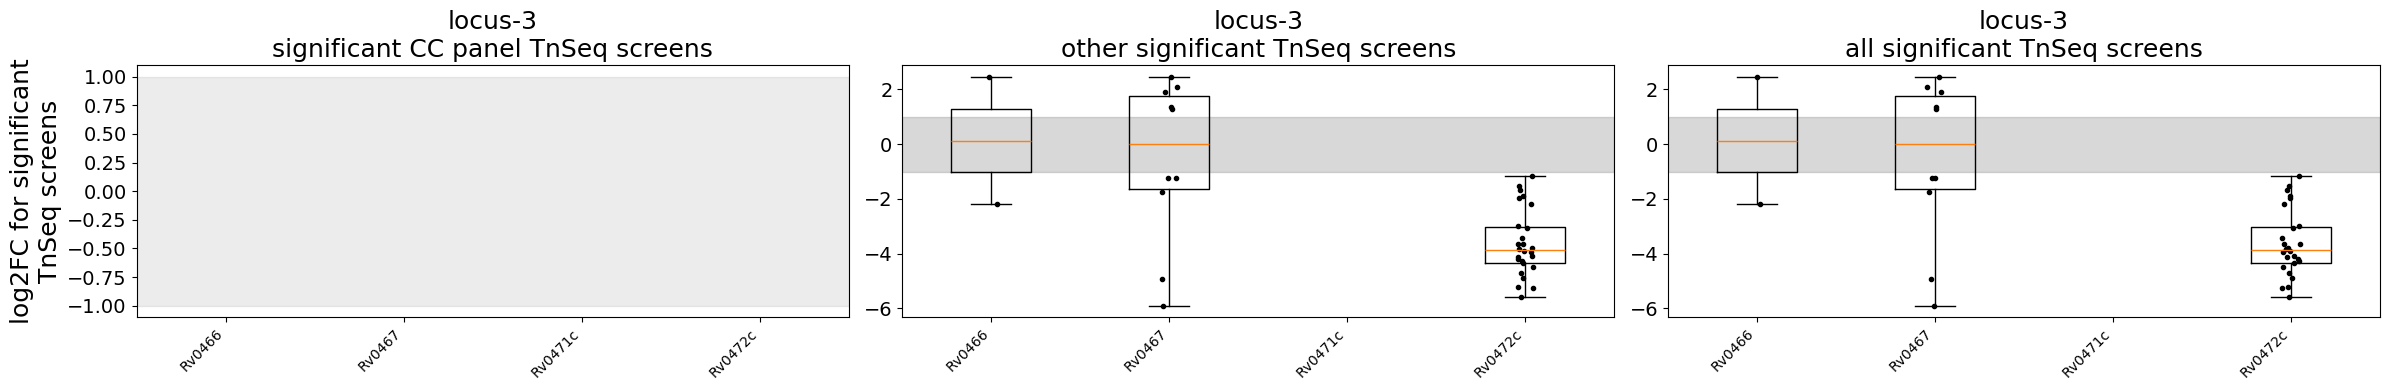

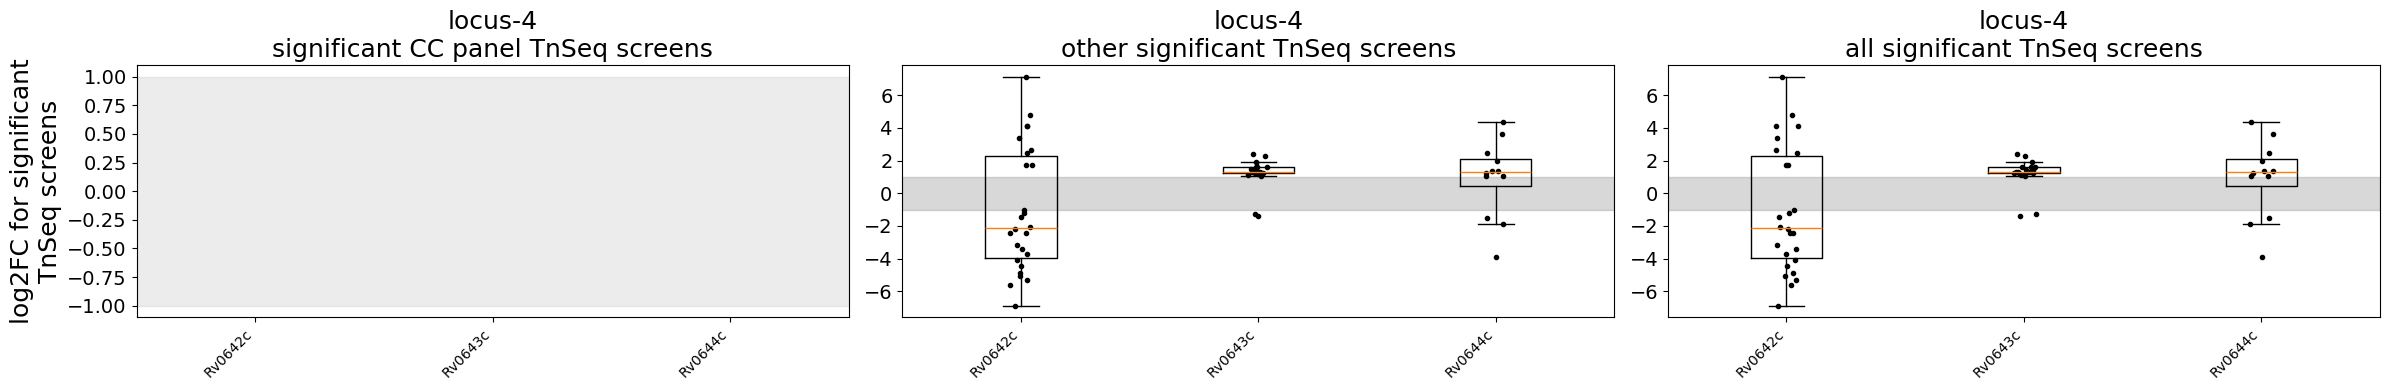

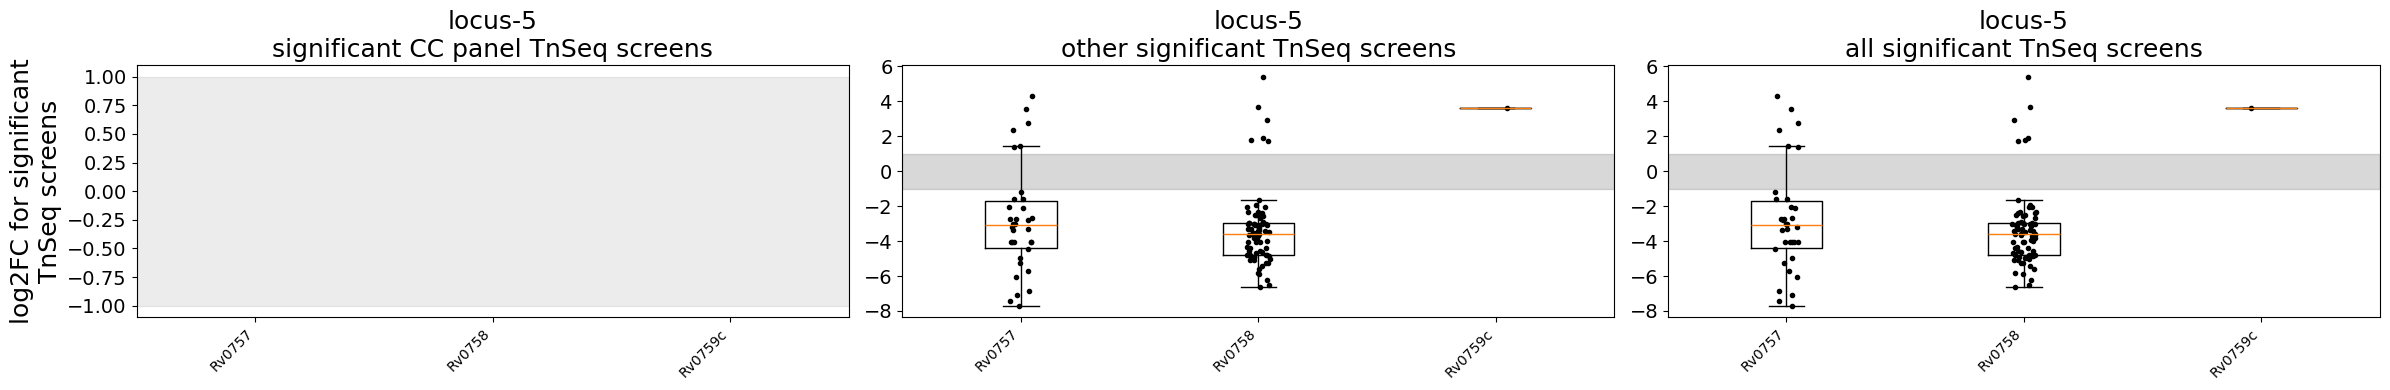

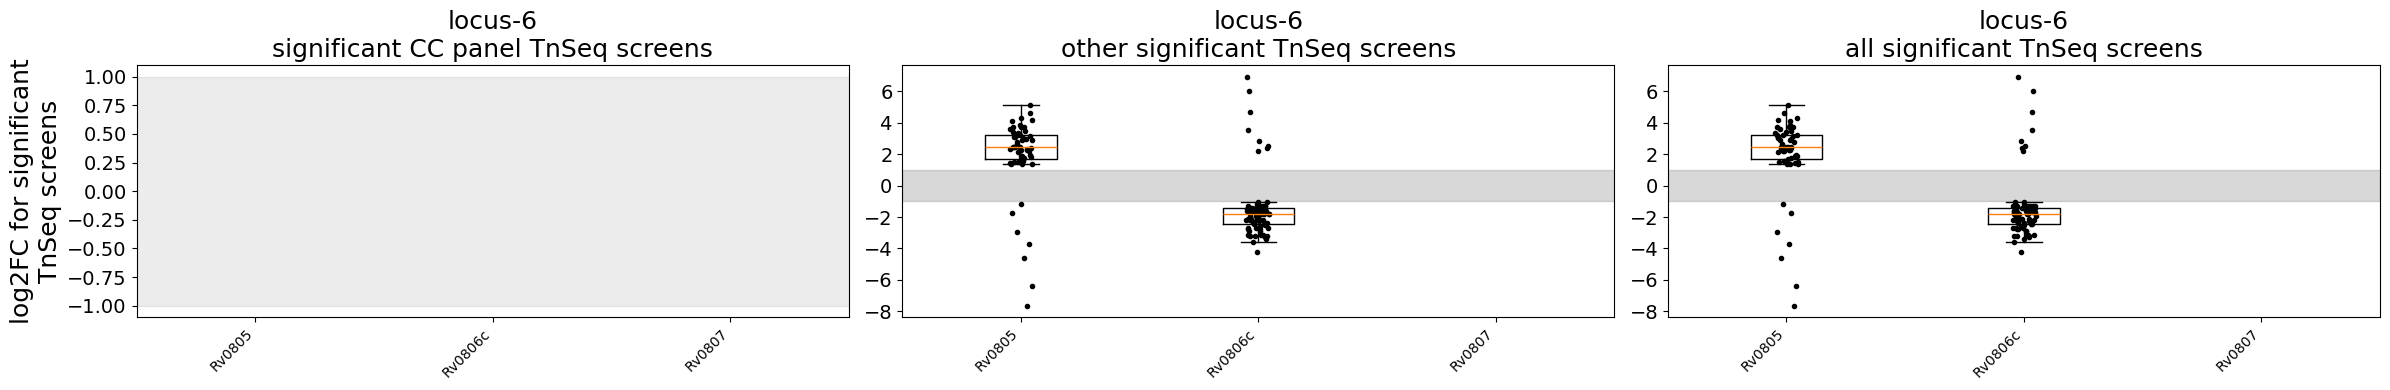

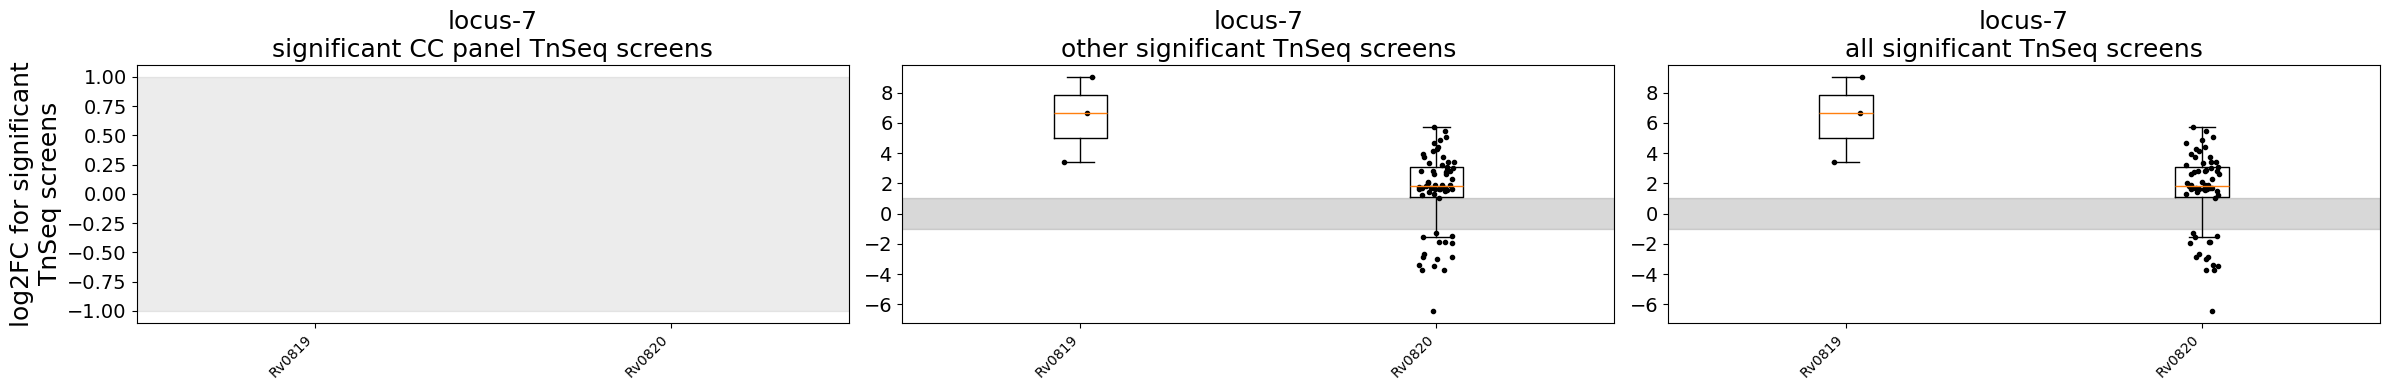

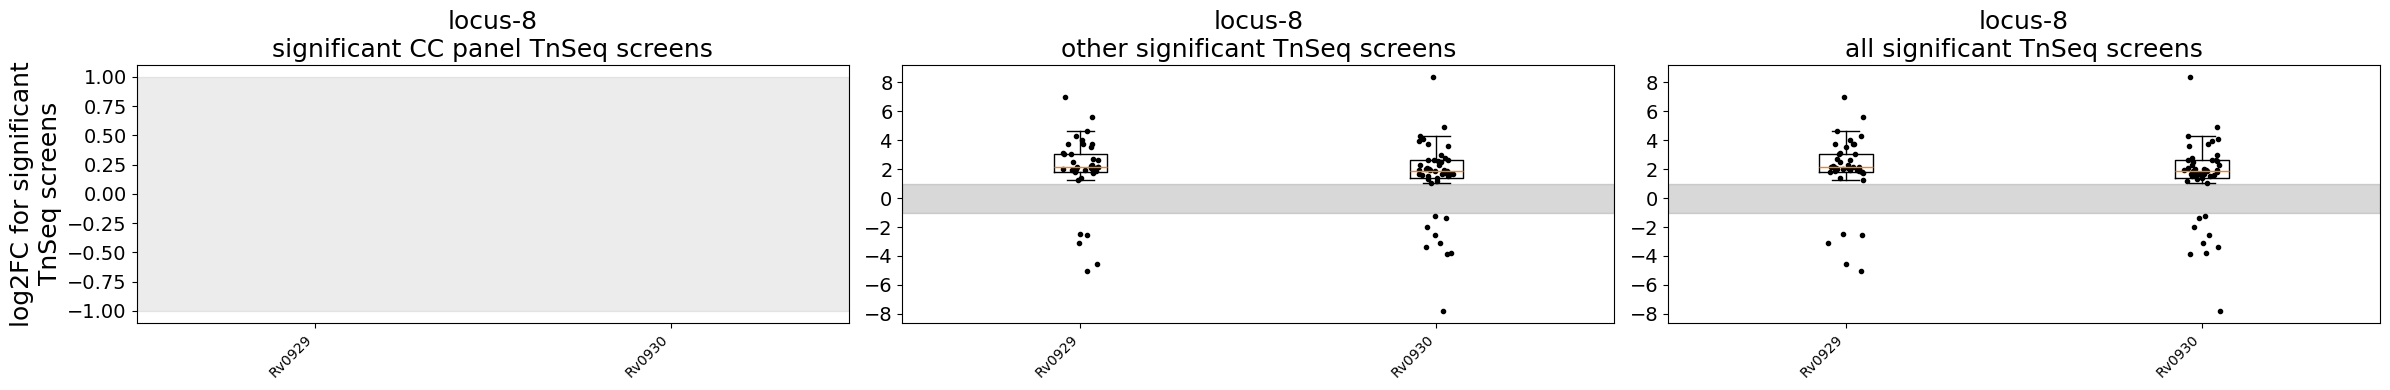

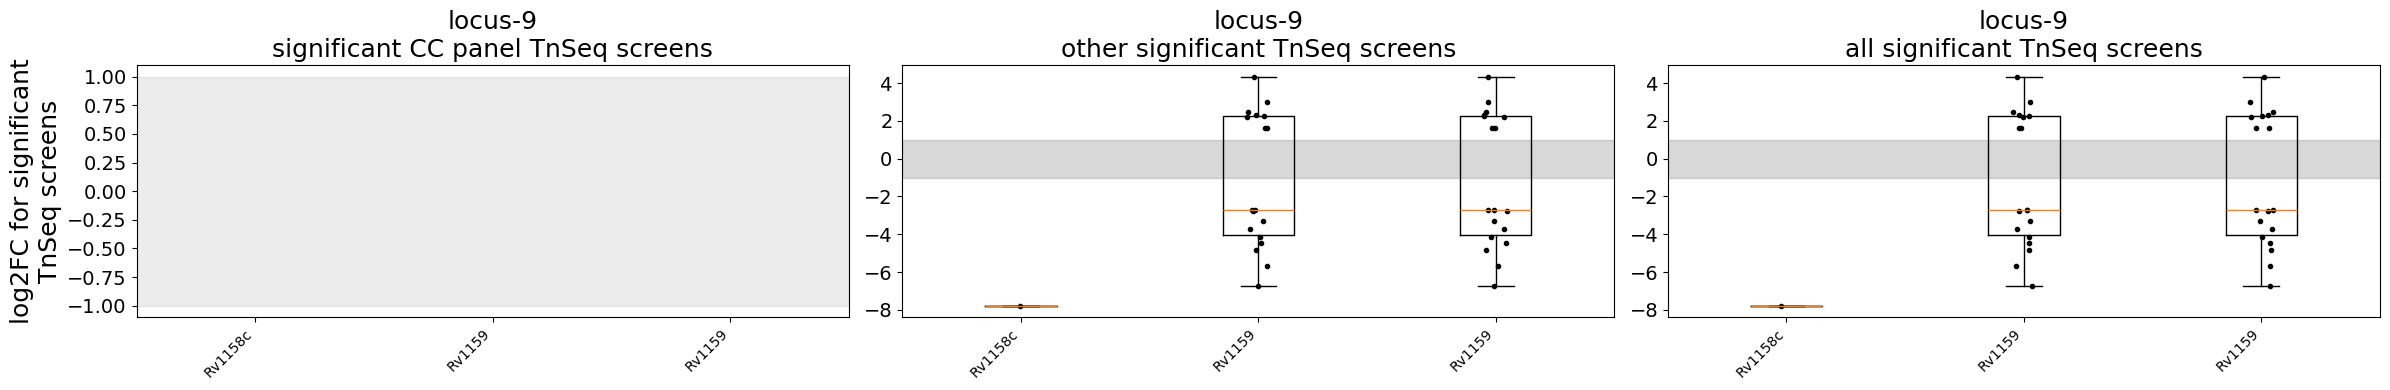

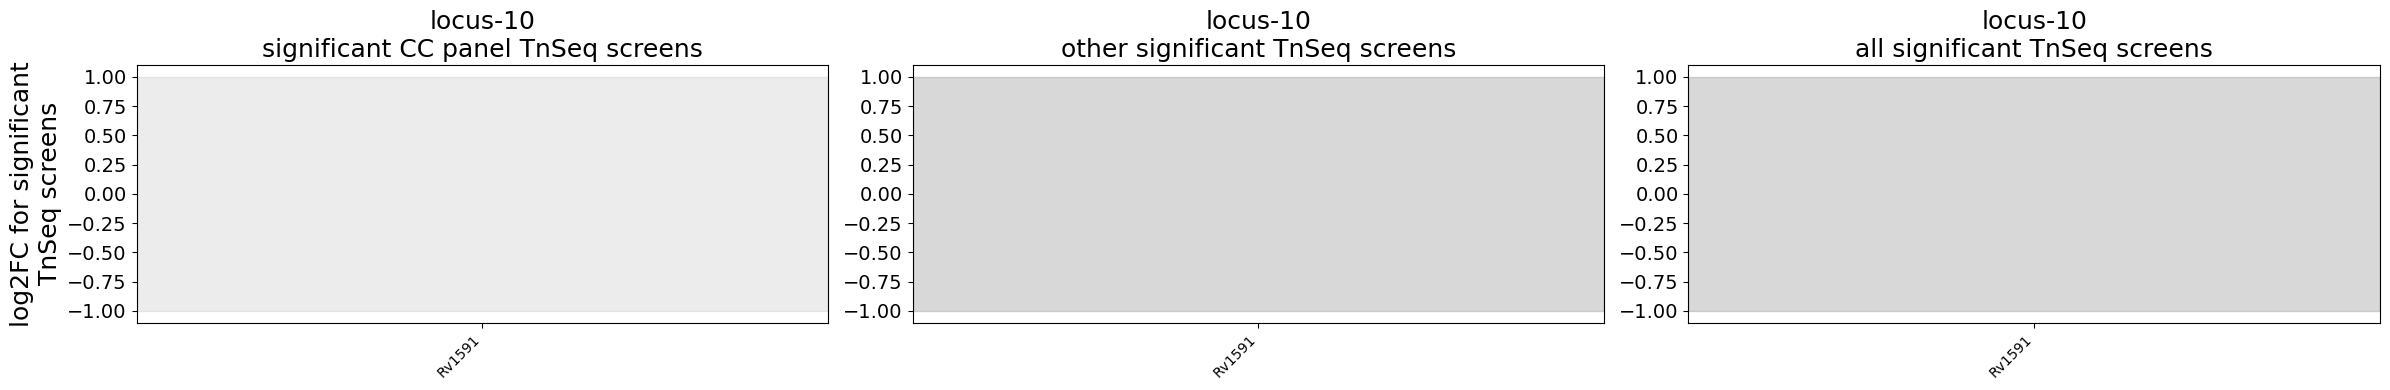

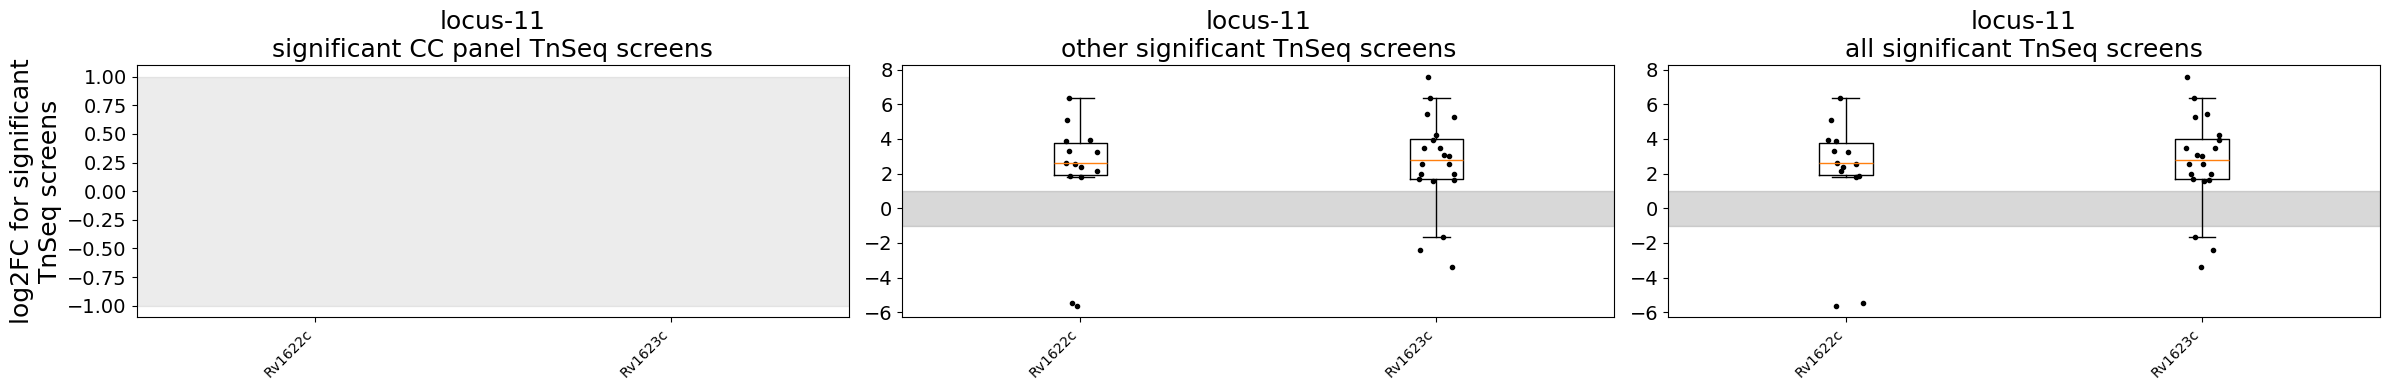

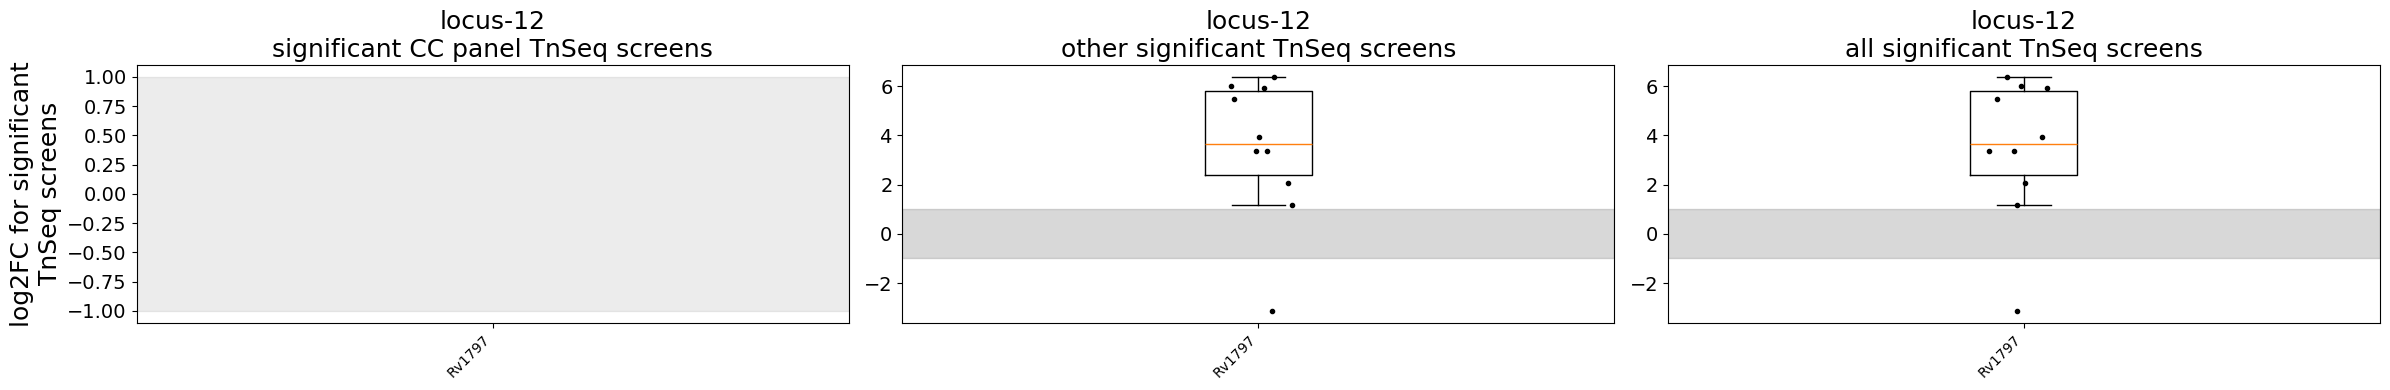

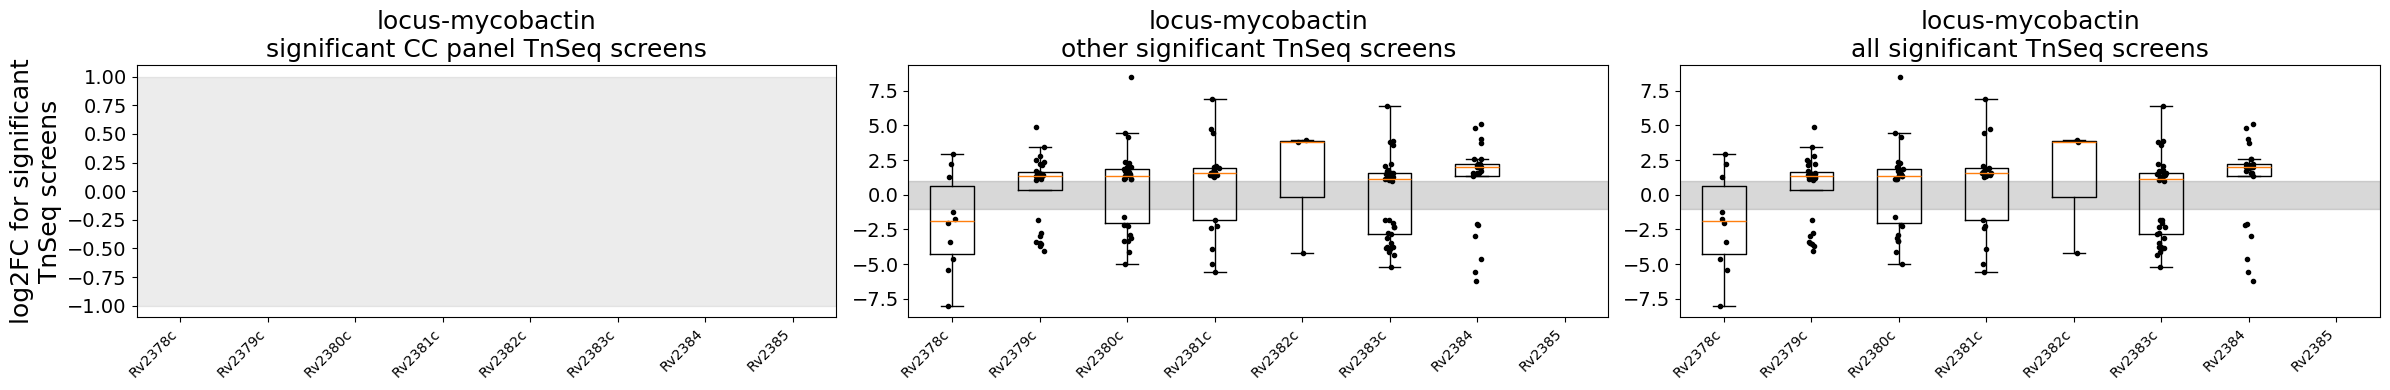

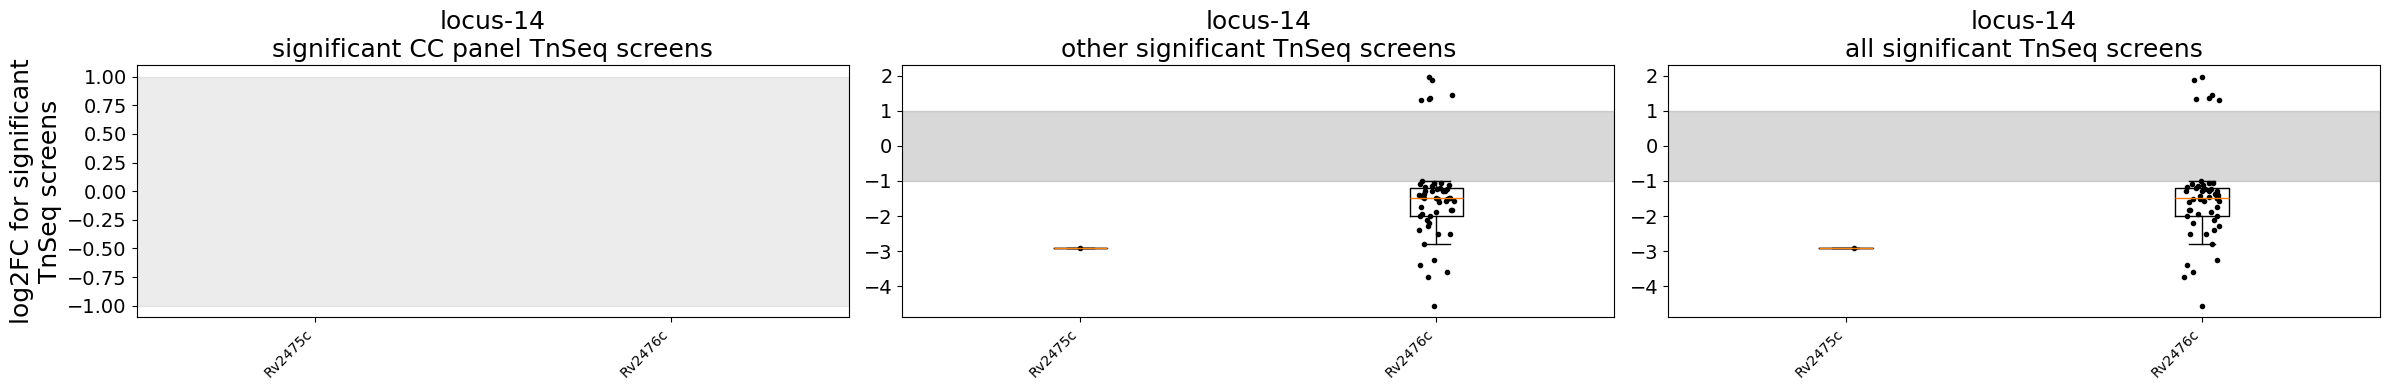

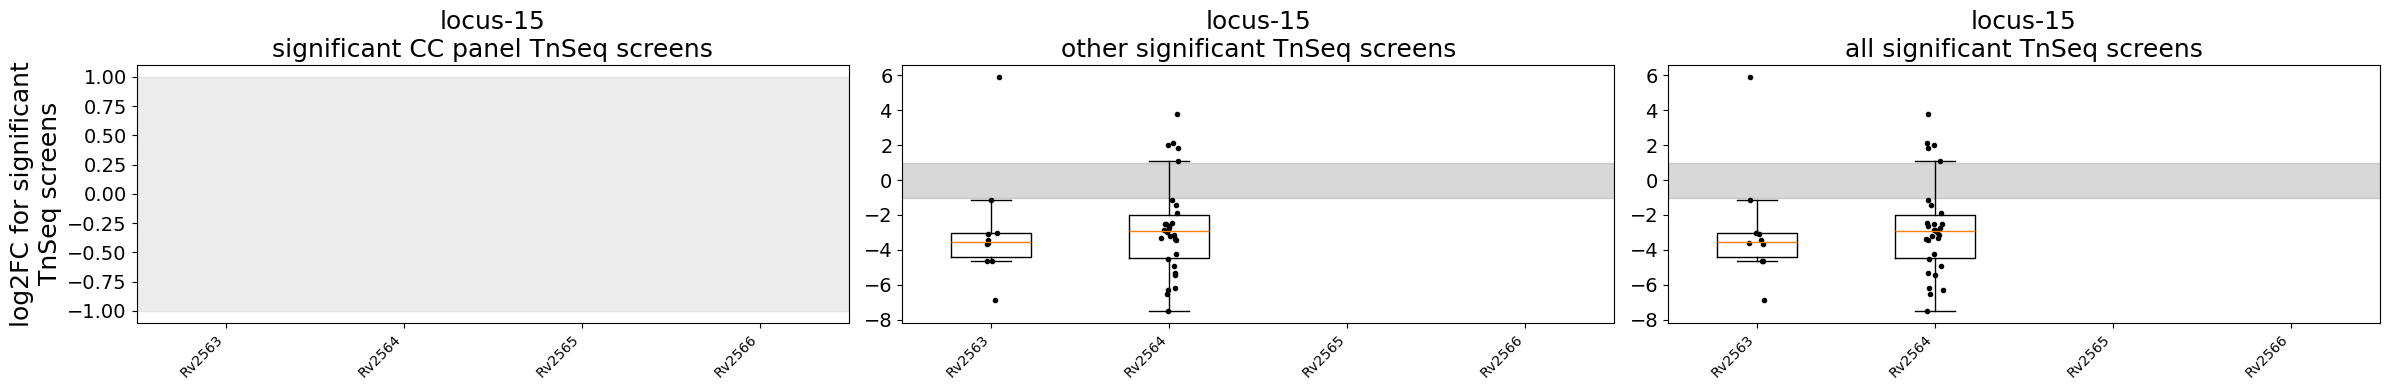

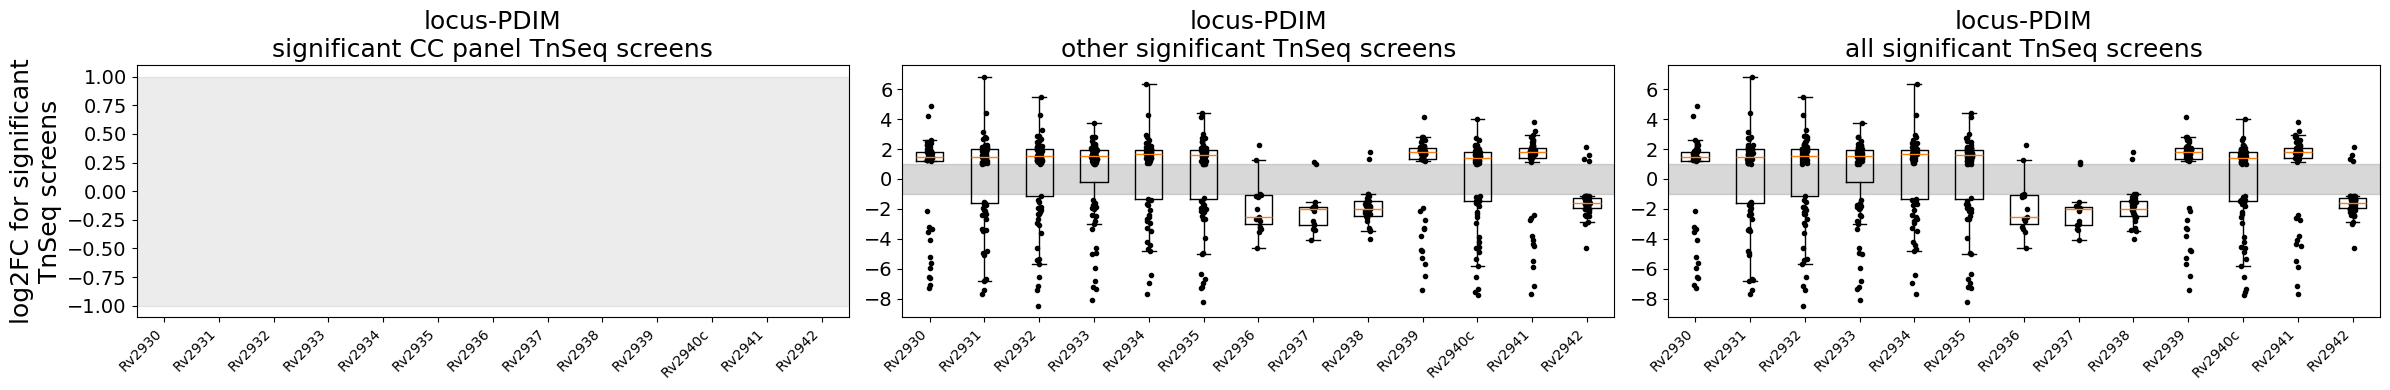

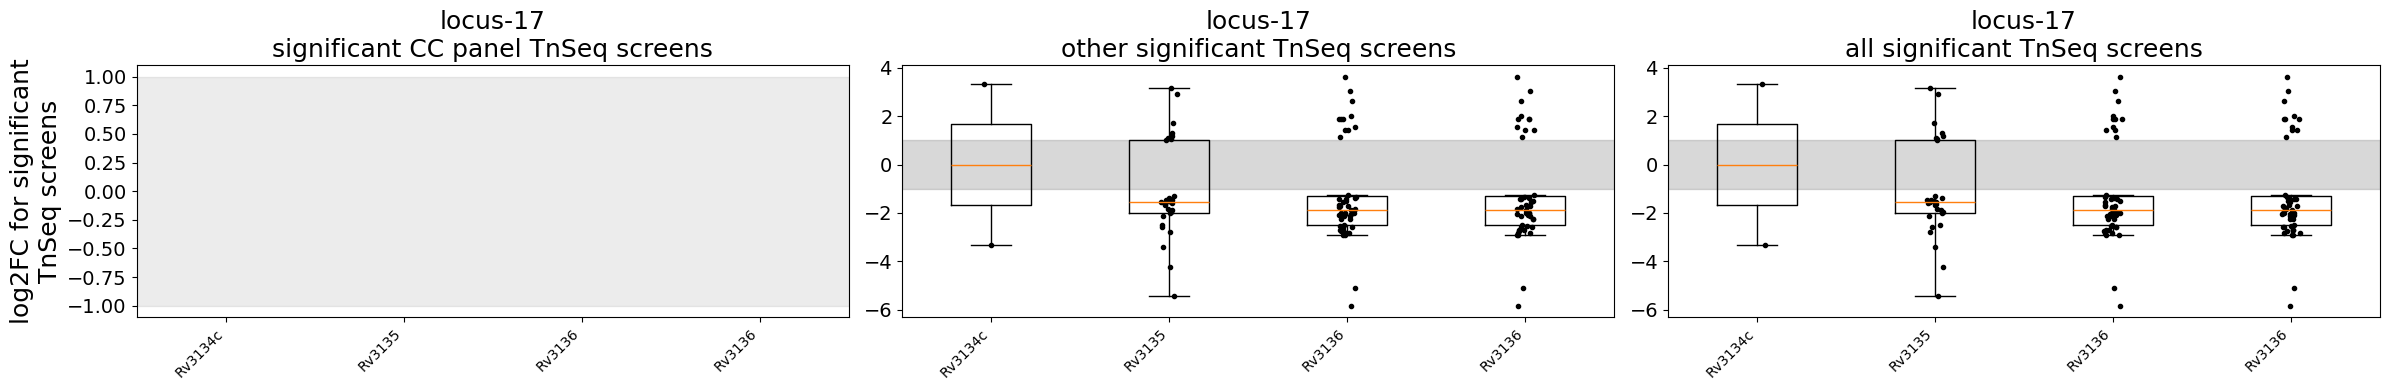

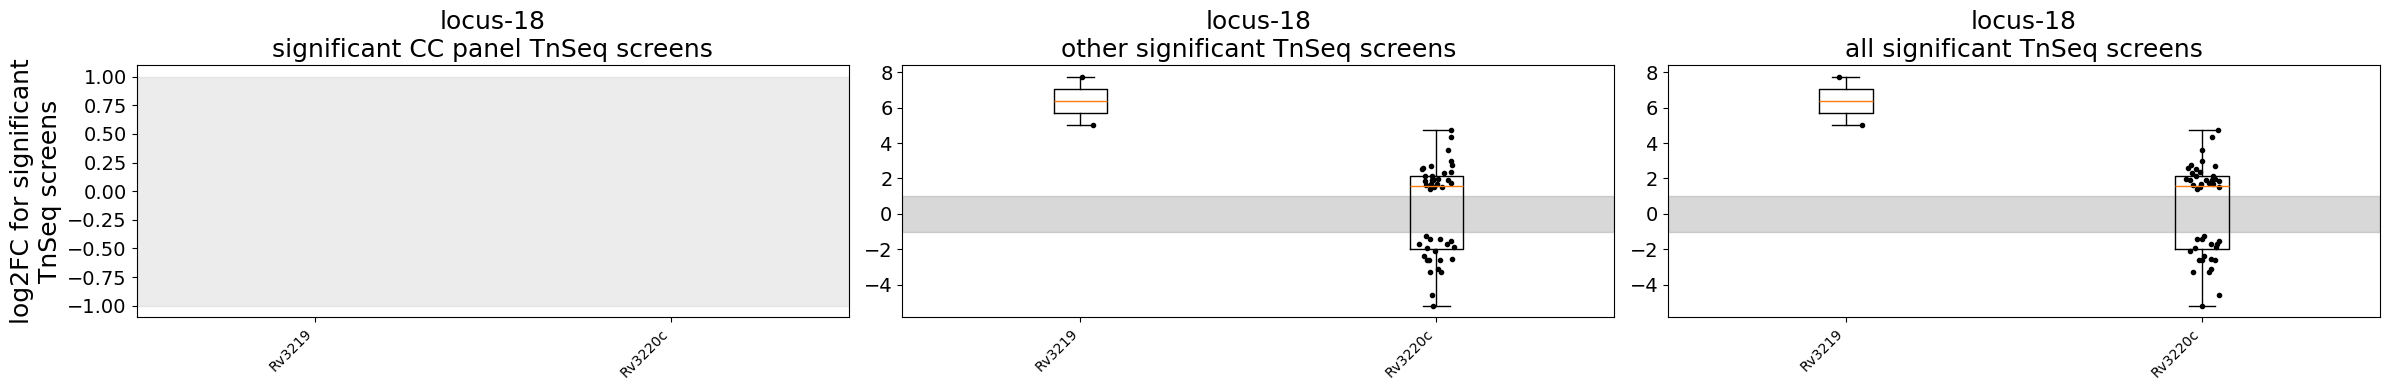

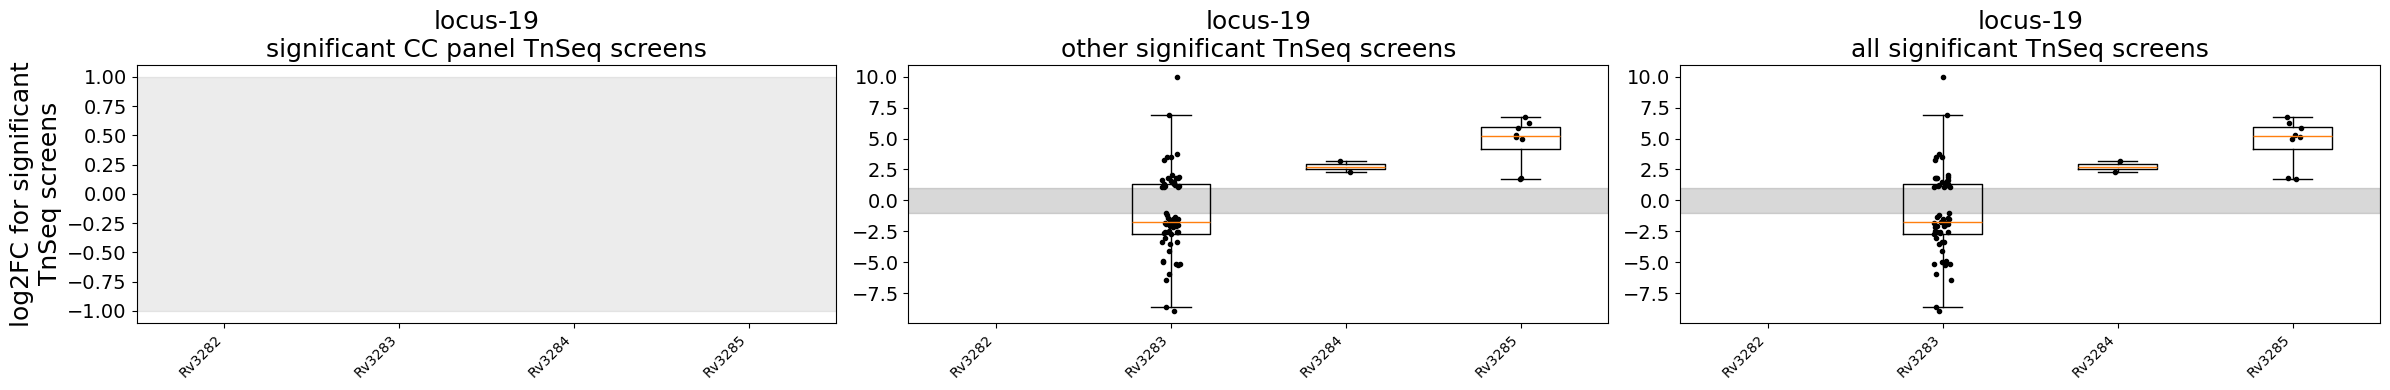

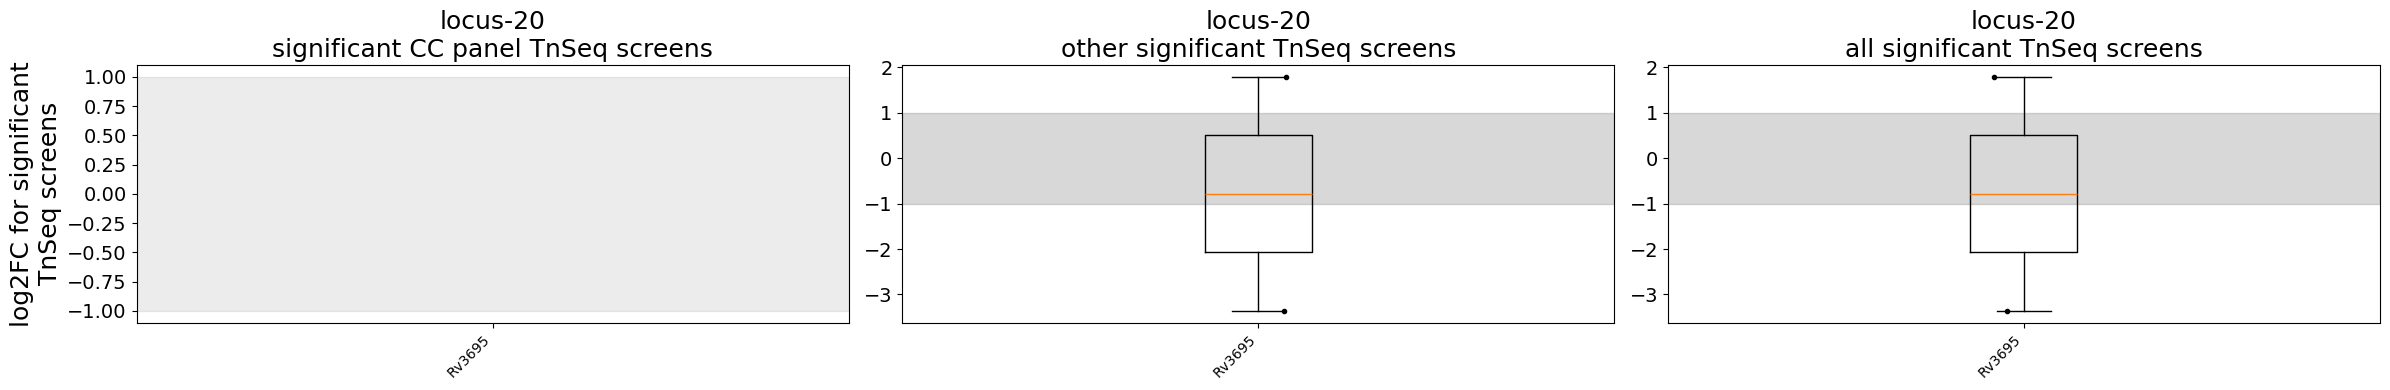

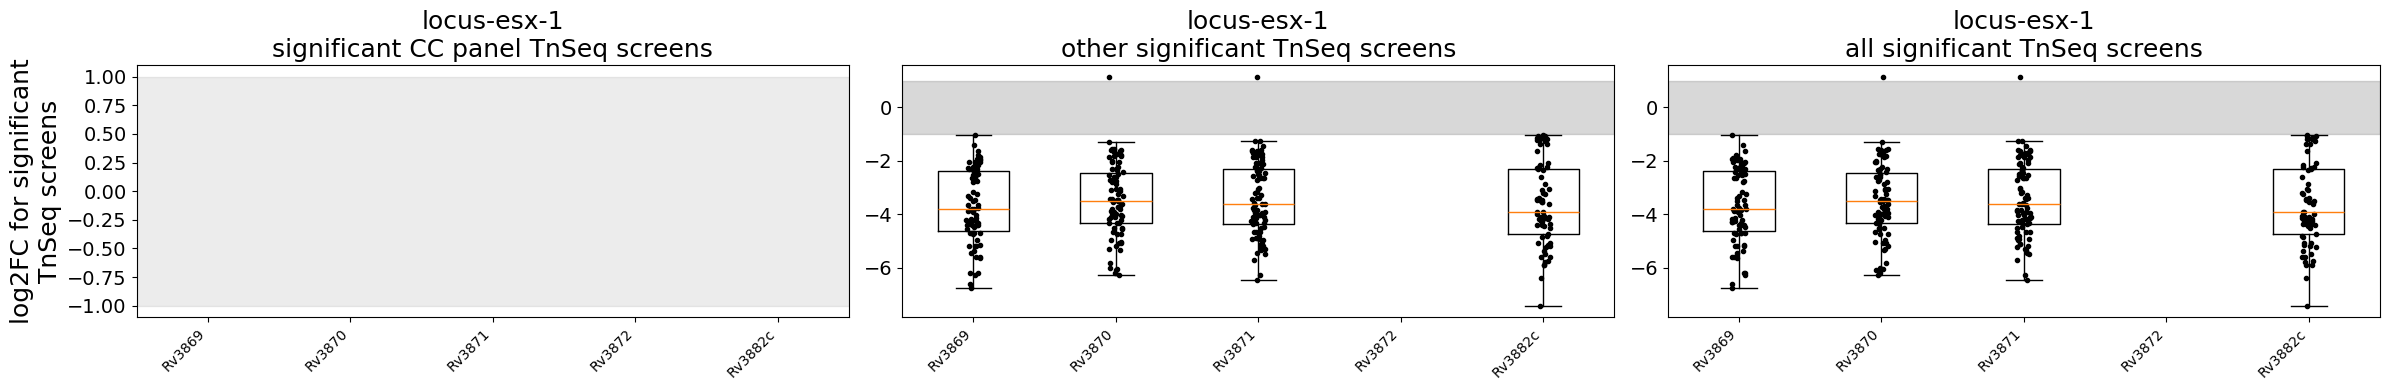

In [38]:
for locus_name in df_loci.locus_name.unique():
    locus_name_str = str(locus_name)
    locus_name_str = 'locus-'+locus_name_str
    list_rv_id = df_loci[df_loci.locus_name == locus_name].Rv_ID.values
    make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name_str)

In [39]:
list_test_noc = ['Rv'+str(i) for i in range(3245,3281)]
list_test_c = [rvid+'c' for rvid in list_test]
list_test = list_test_noc+list_test_c
list_rvid_test = df_up_func[ df_up_func.Rv_ID.isin(list_test) ].Rv_ID.tolist()
list_rvid_test.sort()
locus_name = 'Travis idea locus'
make_loci_boxplots(list_rvid_test, df_bin_annot, df_lfc, locus_name)

NameError: name 'list_test' is not defined

## Other: 

In [ ]:
# df_bin_annot[ (df_bin_annot.Rv_ID.str.contains('Rv292')) |  (df_bin_annot.Rv_ID.str.contains('Rv293')) | (df_bin_annot.Rv_ID.str.contains('Rv294'))][['Rv_ID','gene_name', 'func_tuberculist' ,'sum_CES']]

### Distribution of essentiality counts across genes: 

Let's start with the free stuff:
How many genes are conditionally essential in 10 or more screens? 0 screens?

In [40]:
df_bin[df_bin.sum_CES.values == 0][['Rv_ID', 'sum_CES']].shape

(2285, 2)

In [41]:
df_bin[df_bin.sum_CES.values >= 10][['Rv_ID', 'sum_CES']].shape

(296, 2)

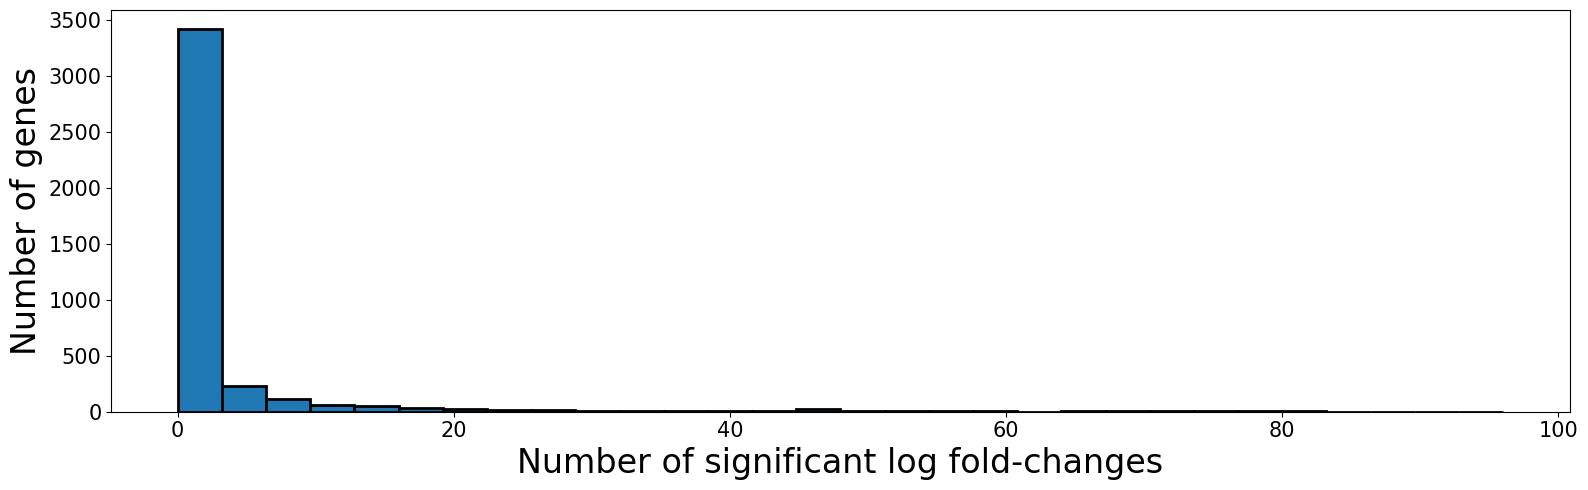

In [42]:
plt.figure(figsize = (16,5))
# hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 40), edgecolor='black', linewidth=2)
hist = plt.hist(df_bin['sum_CES'].values, edgecolor='black', linewidth=2, bins = 30)

plt.xlabel('Number of significant log fold-changes', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'gene_stats_102221.png')
plt.savefig(out_file, dpi = 300)

Quick attempt at CDF plot:

In [43]:
df_bin[df_bin['sum_CES'] >= 25].shape

(124, 148)

In [44]:
df_bin['sum_CES'].max()

96.0

In [45]:
xrange = np.arange(0, 100)
cdf_list = []
for x in xrange:
    cdf_val = len([data for data in df_bin['sum_CES'].values if data <= x]) / len(df_bin['sum_CES'].values)
    cdf_list.append(cdf_val)

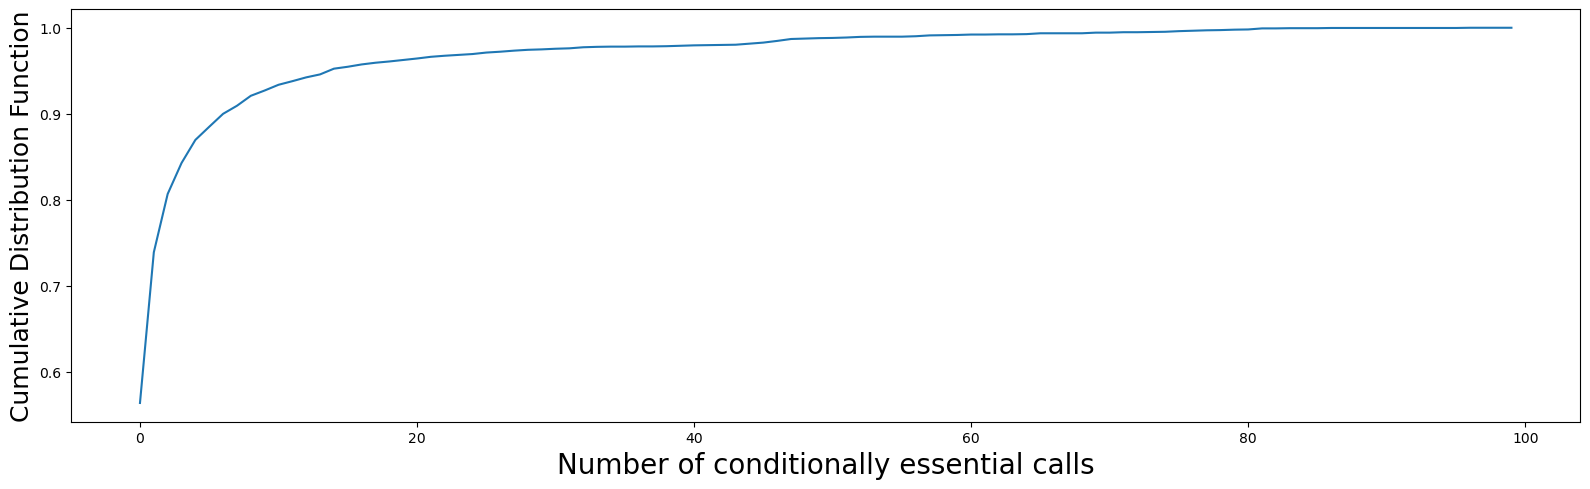

In [46]:
plt.figure(figsize = (16,5))
plt.plot(xrange, cdf_list)
plt.xlabel('Number of conditionally essential calls', fontsize = 20)
plt.ylabel('Cumulative Distribution Function', fontsize = 18)
plt.tight_layout()
plt.savefig('../../figures/gene_stats_CDF_070124.png', dpi=300)

In [47]:
# Number of genes with 0 essentiality counts
zero_essentiality_count = df_bin[df_bin['sum_CES'] == 0].shape[0]
print(f'Number of genes with 0 essentiality counts: {zero_essentiality_count}') #Does this make sense given that with fewer screens there's more? 

Number of genes with 0 essentiality counts: 2285


In [48]:
# Number of genes with >10 essentiality counts
ten_plus_essentiality_counts = df_bin[df_bin['sum_CES'] >= 10].shape[0]
print(f'Number of genes with 0 essentiality counts: {ten_plus_essentiality_counts}')

Number of genes with 0 essentiality counts: 296


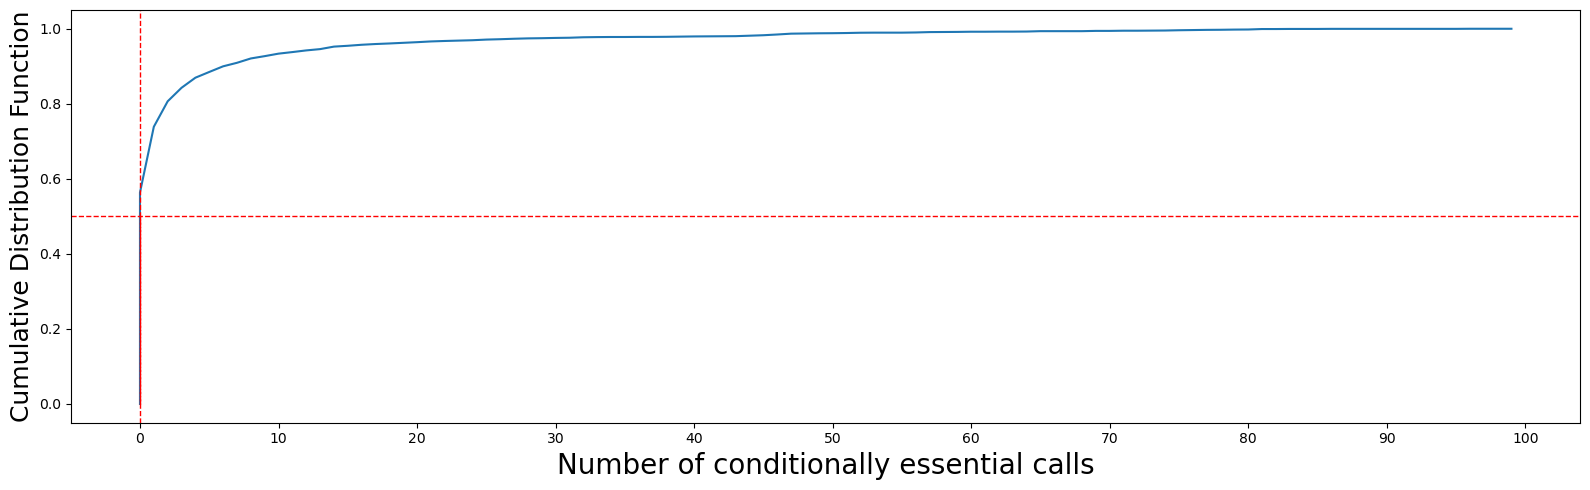

In [49]:
# Assuming df_bin is already defined and contains the necessary data
df_bin[df_bin['sum_CES'] >= 25].shape

# Define the range for the x-axis
xrange = np.arange(0, 100)

# Calculate the CDF
cdf_list = [0]  # Start with the (0,0) point
for x in xrange:
    cdf_val = len([data for data in df_bin['sum_CES'].values if data <= x]) / len(df_bin['sum_CES'].values)
    cdf_list.append(cdf_val)

# Extend xrange to include the (0,0) point
xrange = np.insert(xrange, 0, 0)

# Calculate the median value
median_index = np.searchsorted(cdf_list, 0.5)  # Find the index where the CDF reaches 0.5 (the median)
median_value = xrange[median_index]  # The x-value corresponding to the median

# Plot the CDF
plt.figure(figsize=(16, 5))
plt.plot(xrange, cdf_list, label='CDF')

# Add a red dashed median line
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)  # Horizontal line at the median y-value (0.5)
plt.axvline(x=median_value, color='red', linestyle='--', linewidth=1)  # Vertical line at the median x-value

# Highlight the median with a red dashed box
plt.plot([0, median_value], [0.5, 0.5], 'r--', lw=1)  # Horizontal line segment
plt.plot([median_value, median_value], [0, 0.5], 'r--', lw=1)  # Vertical line segment

# Set x-axis ticks to be spaced by 10 units
plt.xticks(np.arange(0, 101, 10))

# Add labels and title
plt.xlabel('Number of conditionally essential calls', fontsize=20)
plt.ylabel('Cumulative Distribution Function', fontsize=18)
plt.tight_layout()
plt.show()

# Can we identify the core essentials in the 0-bin?

In [50]:
file_mbio = '../../data/SI_datasets/2017A_DeJesus_Iorger/table_1.xlsx'
df_mbio = pd.read_excel(file_mbio)
df_mbio['Final Call'].unique()

array(['ES', 'NE', 'ESD', 'GD', 'Uncertain', 'GA'], dtype=object)

In [51]:
df_mbio_ES = df_mbio[ (df_mbio['Final Call'].values =='ES')].copy()  # | (df_mbio['Final Call'].values =='GD' )].copy() #Which criteria do I want to use? 

df_tn_mbio = df_bin[df_bin.Rv_ID.isin(df_mbio_ES.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio.shape

(461, 2)

In [52]:
x_vals = np.array(df_tn_mbio.sum_CES.value_counts().index)
y_vals = np.array(df_tn_mbio.sum_CES.value_counts().values)

How many of the mbio 2017 essentials have zero conditional essentiality calls?

In [53]:
df_tn_mbio[df_tn_mbio.sum_CES.values==0].shape

(359, 2)

In [54]:
df_tn_mbio[df_tn_mbio.sum_CES.values>0].sort_values(by = 'sum_CES', ascending = False)

,Rv_ID,sum_CES
3765,Rv3645,12.0
2843,Rv2754c,9.0
346,Rv0337c,9.0
3362,Rv3246c,9.0
3418,Rv3302c,9.0
...,...,...
1447,Rv1409,1.0
1880,Rv1832,1.0
3376,Rv3260c,1.0
1166,Rv1133c,1.0


In [55]:
rvid = 'Rv3277'
cols = df_bin.columns

[col for col in cols if df_bin[df_bin.Rv_ID == rvid][col].values[0] == 1]

['carey_621_vs_carey_rv',
 'carey_631_vs_carey_rv',
 'carey_632_vs_carey_rv',
 'carey_641_vs_carey_rv',
 'carey_662_vs_carey_rv',
 'carey_667_vs_carey_rv',
 'mbio_H37Rv_vs_in_vitro']

In [56]:
# Print the column names of the DataFrame
print(df_lfc.columns)

# Check if the column exists
if col_temp in df_lfc.columns:
    print(f"Column '{col_temp}' exists in the DataFrame.")
else:
    print(f"Column '{col_temp}' does not exist in the DataFrame.")


Index(['Rv_ID', 'PE35_KO_vs_mbio_H37Rv', 'PPE68_KO_vs_mbio_H37Rv',
       'Rv0950c_KO_vs_CB_WT', 'Rv0954_KO_vs_RJ_WT', 'Rv1096_KO_vs_CB_WT',
       'Rv3005c_KO_day32_vs_dejesus_H37Rv_day32',
       'Rv3594_KO_vs_Rubin_FLUTE_WT', 'Rv3684_KO_vs_CB_WT',
       'Rv3717_KO_vs_Rubin_FLUTE_WT',
       ...
       'BXD69_vs_in_vitro_H37Rv', 'BXD73_vs_in_vitro_H37Rv',
       'BXD73b_vs_in_vitro_H37Rv', 'BXD77_vs_in_vitro_H37Rv',
       'BXD79_vs_in_vitro_H37Rv', 'BXD9_vs_in_vitro_H37Rv',
       'BXD90_vs_in_vitro_H37Rv', 'BXD93_vs_in_vitro_H37Rv',
       'C57BL.6J_vs_in_vitro_H37Rv', 'DBA.2J_vs_in_vitro_H37Rv'],
      dtype='object', length=147)


NameError: name 'col_temp' is not defined

In [57]:
col_temp = 'CC012.GeniUnc_vs_C57BL.6J'
rvid = 'Rv3277'
df_lfc[df_lfc.Rv_ID == rvid][col_temp]

KeyError: 'CC012.GeniUnc_vs_C57BL.6J'

Show these in the histogram: 

In [ ]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [ ]:
num_disp = df_bin[df_bin.sum_CES.values == 0].shape[0]

In [ ]:
num_ES = df_mbio_ES.shape[0]

plt.figure(figsize = (16,5))

hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 21), color=current_palette[0], edgecolor='black', linewidth=2)
plt.bar(0, num_disp, color = current_palette[2], width=1, edgecolor='k', linewidth=2, alpha=0.85)
plt.bar(x_vals, y_vals, color = current_palette[3], width=1, edgecolor='k', linewidth=2, alpha=0.85)

# sns.distplot(df_tn['sum_all'].values, bins = np.arange(-0.5, 21))
plt.xlabel('Number of conditional essentiality calls', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)
plt.legend(['conditionally essentials', 'putatively dispensable (*)','$\it{in}$ $\it{vitro}$ essentials (DeJesus et al. 2017)'], fontsize = 24)
plt.tight_layout()

# out_file = os.path.join(dir_figs, 'gene_stats.png')
# plt.savefig(out_file, dpi = 300)

##### New version (02/01/2021)

In [58]:
# for the new version of the plot
df_mbio_ES_ONLY = df_mbio[ (df_mbio['Final Call'].values =='ES')].copy()
df_mbio_GD = df_mbio[ (df_mbio['Final Call'].values =='GD' )].copy()
df_mbio_GA = df_mbio[ (df_mbio['Final Call'].values =='GA' )].copy()
df_mbio_NE = df_mbio[ (df_mbio['Final Call'].values =='NE' )].copy()

# 
df_tn_mbio_ES_ONLY = df_bin[df_bin.Rv_ID.isin(df_mbio_ES_ONLY.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_GD = df_bin[df_bin.Rv_ID.isin(df_mbio_GD.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_GA = df_bin[df_bin.Rv_ID.isin(df_mbio_GA.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_NE = df_bin[df_bin.Rv_ID.isin(df_mbio_NE.Rv_ID)][['Rv_ID', 'sum_CES']]

# 
xbins = np.arange(-0.5, 25.5, 1)
yx_vals_ES_ONLY = np.histogram(df_tn_mbio_ES_ONLY.sum_CES.values, bins = xbins)
yvals_ES_ONLY = yx_vals_ES_ONLY[0]

yx_vals_GD = np.histogram(df_tn_mbio_GD.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_GD = yx_vals_GD[0]

yx_vals_GA = np.histogram(df_tn_mbio_GA.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_GA = yx_vals_GA[0]

yx_vals_NE = np.histogram(df_tn_mbio_NE.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_NE = yx_vals_NE[0]

In [59]:
df_tn_mbio_ES_ONLY[df_tn_mbio_ES_ONLY.sum_CES.values == 0].shape[0] + df_tn_mbio_GD[df_tn_mbio_GD.sum_CES.values == 0].shape[0]

418

In [60]:
xvals_ALL = np.arange(0, 25)

In [61]:
plt.figure(figsize = (16,5))
lw_param = 0.5

hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 21), color=current_palette[-3], edgecolor='black', linewidth=lw_param)

plt.bar(xvals_ALL, yvals_NE, color = current_palette[0], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = yvals_NE
plt.bar(xvals_ALL, yvals_ES_ONLY, bottom=arr_bottom , color = current_palette[1], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = arr_bottom + yvals_ES_ONLY
plt.bar(xvals_ALL, yvals_GA, bottom=arr_bottom , color = current_palette[2], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = arr_bottom + yvals_GA
plt.bar(xvals_ALL, yvals_GD, bottom=arr_bottom , color = current_palette[3], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

plt.legend(['other', '$\it{in}$ $\it{vitro}$ non-essential (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ essential (DeJesus et al. 2017)', 
           '$\it{in}$ $\it{vitro}$ growth-advantage (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ growth-defect (DeJesus et al. 2017)'], fontsize = 18)

plt.xlabel('Number of conditional essentiality calls', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)

plt.tight_layout()

out_file = os.path.join(dir_figs, 'gene_stats_v2.png')
plt.savefig(out_file, dpi = 300)

<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_22042/3111509176.py:17: SyntaxWarning: invalid escape sequence '\i'
  plt.legend(['other', '$\it{in}$ $\it{vitro}$ non-essential (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ essential (DeJesus et al. 2017)',
/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_22042/3111509176.py:17: SyntaxWarning: invalid escape sequence '\i'
  plt.legend(['other', '$\it{in}$ $\it{vitro}$ non-essential (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ essential (DeJesus et al. 2017)',
/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipy

NameError: name 'current_palette' is not defined

<Figure size 1600x500 with 0 Axes>

In [62]:
file_out = '../../data/annotations/data_for_Michael_1.csv'
df_bin.to_csv(file_out, index = False)

file_out = '../../data/annotations/data_for_Michael_2.csv'
df_mbio.to_csv(file_out, index = False)

Which have 1 or more conditional essentiality calls?

In [63]:
rvid_ES_CES = df_tn_mbio[df_tn_mbio.sum_all>0].Rv_ID.values

AttributeError: 'DataFrame' object has no attribute 'sum_all'

In [64]:
def essentiality_calls(df, gene_id):
# Return the columns in which a given gene is called essential:
    cols = df.columns[1:]
    col_list = []
    for col in cols:
        if df[df['Rv_ID']==gene_id][col].values[0] == 1:
            col_list.append(col)
            
    return col_list

In [65]:
CES_list = []
for gene_id in rvid_ES_CES:
    CES_list.append(essentiality_calls(df_tn, gene_id))
df_ES_CES = pd.DataFrame()
df_ES_CES['Rv_ID'] = rvid_ES_CES
df_ES_CES['CES_calls'] = ['; '.join(CES[:-1]) for CES in CES_list]

NameError: name 'rvid_ES_CES' is not defined

In [66]:
file_out = '../../dep/data/ES_with_CES_calls.csv'
df_ES_CES.to_csv(file_out, index = False)

NameError: name 'df_ES_CES' is not defined

In [ ]:
df_ES_CES[df_ES_CES.CES_calls.str.contains('carey')].shape

### Which genes are the tail of the distribution?

In [ ]:
df_tn_top_wName = df_tn_top.merge(df_mbio, how = 'left', on = 'Rv_ID')[['Rv_ID', 'sum_all', 'Name']]
file_out = '../../data/top_genes_CES_calls.xlsx'
df_tn_top_wName.to_excel(file_out, index= False)

### Cumulative distribution:

In [ ]:
myrange = np.arange(df_tn['sum_all'].max())
cdf = np.zeros(len(myrange))
for n in myrange:
    cdf[int(n)] = df_tn[df_tn.sum_all<=n].shape[0] / df_tn.shape[0]

In [ ]:
plt.figure(figsize = (14,6))
plt.plot(myrange, cdf, '-o', lw = 4, ms = 10)
xt = plt.xticks( np.arange(0, df_tn['sum_all'].max(), 2), fontsize = 20)
plt.ylim(0, 1.1)
yt = plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 20)
plt.xlabel('number of essentiality calls', fontsize = 30)
plt.ylabel('cumulative distribution', fontsize = 27)
plt.grid(True, xdata = myrange)
plt.tight_layout()
